https://stackoverflow.com/questions/53838696/problems-regarding-pyomo-provided-math-functions

https://stackoverflow.com/questions/70048818/optimization-of-a-battery-storage-with-pyomo

https://gitlab.com/diw-evu/emobpy/emobpy/-/blob/master/emobpy/data/evspecs.json

https://github.com/L-Strobel/jointAnalysisCharging/tree/main/chargingmodel

In [181]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt#
import matplotlib.axes as axes
import pyomo.environ as pyo 
import pyomo.opt as opt
from IPython.display import clear_output
from pyomo.opt import SolverFactory
import random
from pandas import Timestamp
import pickle
import matplotlib.dates as mdates

## Data input 

In [182]:
V2G = False
short_or_long = "medium" #short: short, medium, long
flex = "constrained" #constrained meaning that late charging cannot be applied to the fullest extent
soc_min = 0 #level that should preferably be reached as soon as possible

In [340]:
#emobpy import
processing_path = os.getcwd()
os.chdir(f"/Users/Jarusch/Documents/EES/{short_or_long}")
    #f"../emobpy/{s hort_or_long}")

data_path = os.getcwd()
os.chdir(processing_path)
pics = os.path.join(processing_path, "Pictures","V2G" if V2G else "G2V", short_or_long)
if soc_min >0: 
    os.makedirs(os.path.join(processing_path, "Pictures", f"{soc_min}"), exist_ok = True)
    pics = os.path.join(processing_path, "Pictures", f"{soc_min}")

pics_input = os.path.join(pics, "input")

    

consumption_ts = pd.read_pickle(os.path.join(data_path,  "consumption"))
#consumption_ts = consumption_ts*100 
availability_ts = pd.read_pickle(os.path.join(data_path, "availability"))
car_properties_raw = pd.read_pickle(os.path.join(data_path,  "properties")) 

profiles = min(consumption_ts.shape[1], availability_ts.shape[1], car_properties_raw.shape[1])

time_steps = len(availability_ts.dropna().index)

In [341]:
profiles

19932

In [342]:
car_properties_raw.iloc[0] = 1
car_properties_raw.iloc[1] = 1

In [343]:
#consumption = pd.DataFrame(data = np.array([[0, 0.5], [0, 0.5], [0.5, 0], [0.5, 0]]), columns = ["c_1[kW]", "c_2[kW]"])
#power = pd.DataFrame(pd.DataFrame(data = np.array([[1, 0], [1, 0], [0, 1], [0, 1]]), columns = ["p_1 [kW]", "p_2 [kW]"]))

#kWh / 15 min timestep
consumption_raw, power_raw, car_properties_raw = consumption_ts.iloc[:time_steps, :profiles].dropna(), availability_ts.iloc[:time_steps, :profiles].dropna(), car_properties_raw.iloc[:, :profiles].dropna()
neg_power_magnitude_raw = power_raw

#set datetime indexes 
index = consumption_ts.index[:time_steps]
consumption_raw.index, power_raw.index, neg_power_magnitude_raw.index = index, index, index

In [344]:
step_duration = int(pd.infer_freq(index)[:-1]) / 60  #parts of an hour

## Data plausibility

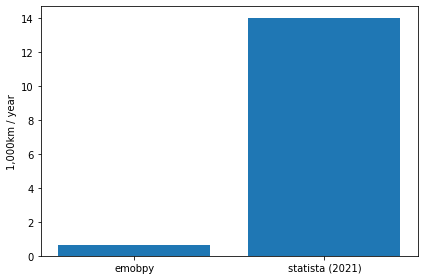

In [8]:
#average consumption of 200Wh per km  https://de.statista.com/statistik/daten/studie/183003/umfrage/pkw---gefahrene-kilometer-pro-jahr/, https://ev-database.de/cheatsheet/energy-consumption-electric-car 
#median in Germany is at about 11000 km per year
if soc_min ==0:  
    specific_consumption = 18 #for consumtion [kWh]  / [kWh/km]  = km
    scale = 365/len(consumption_raw.resample("D").sum().index)

    plot = plt.bar(
        ["emobpy", "statista (2021)"], [consumption_raw.sum(0).mean()*scale/specific_consumption/1000, 14]
           )
    plt.ylabel("1,000km / year")
    plt.tight_layout()

    #plt.savefig(os.path.join(pics_input, 'annual_mileage.png'),bbox_inches = "tight")

In [190]:
np.unique(power_raw.values) 

array([0.0, 3.33, 19.8], dtype=object)

In [345]:
#flexibility only available at home or at workplace 
flex_dict = {
    3.33 : {
        "time_steps" : 1    
    }
}
flex_dict[3.33]

{'time_steps': 1}

In [192]:
week_list = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
def groupby_weekday(df):
    return df.groupby(df.index.day_name()).sum().reindex(week_list) 

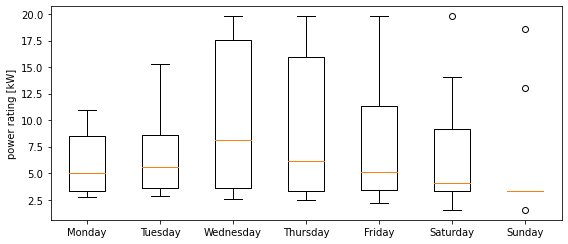

In [12]:
#power ratings are mostly between 3 and 20 kW 
if soc_min ==0:  
    ts = power_raw.loc[(index.day<=7) & (index.month==1)].resample("D").mean()
    ts = ts.groupby(ts.index.day_name()).sum().reindex(week_list) 
    
    fig, ax = plt.subplots(figsize=(8, 3.5))
    ax.boxplot(
        ts.transpose(), labels= ts.index,
          )

    plt.ylabel('power rating [kW]')

    fig.tight_layout()
    #plt.savefig(os.path.join(pics_input, 'average_power_rating.png'), bbox_inches = "tight")

#power ratings are mostly between 3 and 20 kW 
if soc_min ==0:  
    ts = power_raw.loc[(index.day<=7) & (index.month==1)].resample("12h").mean()
    fig, ax = plt.subplots(figsize=(8, 3.5))
    ax.boxplot(
        ts.transpose(), labels= [d[:3] + "/" + str(h) for d, h in zip(ts.index.day_name(), ts.index.hour)],
          )

    plt.ylabel('power rating [kW]')

    fig.tight_layout()
    plt.savefig(os.path.join(pics_input, 'average_power_rating.png'), bbox_inches = "tight")

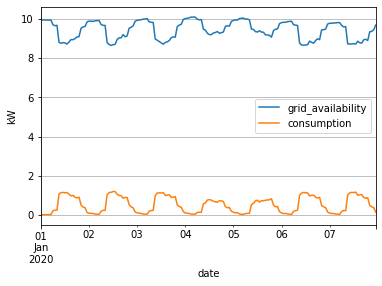

In [193]:
if soc_min ==0:  

    ts = pd.concat([power_raw.mean(1), consumption_raw.mean(1)], axis=1, keys=["grid_availability", "consumption"] ).resample("H").mean()
    ts = ts[(ts.index.day <8) & (ts.index.month ==1)]
    ts.plot(ylabel="kW")
    plt.grid()
    #plt.savefig(os.path.join(pics_input, 'consumtion_power_availability.png'), bbox_inches = "tight")

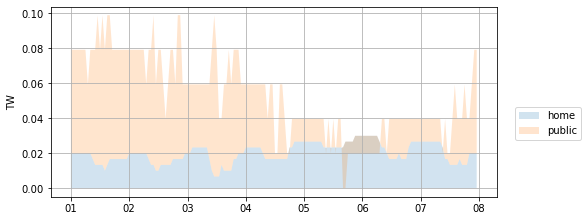

In [14]:
## bottom = 0
rating = 1
rating_weighted = True
station_dict = {0.0 : "none",
               3.33 : "home",
               19.8: "public"}
fig, ax = plt.subplots(figsize=(8, 3.5))
i = 0
bottom = 0
ts = power_raw.resample("H").mean()
ts = ts[(ts.index.day <8) & (ts.index.month ==1)]
for r in np.unique(power_raw.values):
    if rating_weighted == True: 
        rating = r
        if (r != 0): 
            next_bottom = bottom+ts[ts==r].count(1)*rating 
        else: continue
        
    else: 
        next_bottom = bottom+ts[ts==r].count(1)*rating / ts.shape[1]
    if r in station_dict.keys(): l = station_dict[r] 
    else: 
        l = f'fast_{1}'
        i +=1
    next_bottom = next_bottom*10**-3
    plt.fill_between(x = ts.index,
                y1 = bottom,
                y2 = next_bottom,
                alpha = 0.2,
                label = l)
    bottom = next_bottom

ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d'))
plt.ylabel('TW' if rating_weighted else "%")
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0.5))
plt.grid()

#if soc_min ==0: plt.savefig(os.path.join(pics_input, f'home_charging_shares{"_per_cent" if rating_weighted else "_kw"}.png'),bbox_inches = "tight") 

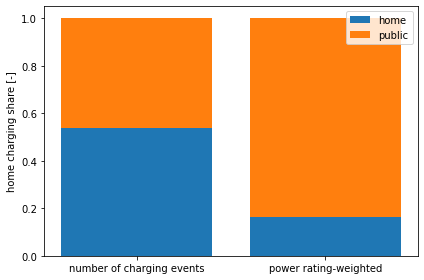

In [15]:
if soc_min ==0:  
    home_share_events = power_raw[power_raw==3.33].count().sum() / power_raw[power_raw>0].count().sum()
    home_share_rating = power_raw[power_raw==3.33].sum().sum() / power_raw.sum().sum()


    plt.bar(
        ["number of charging events", "power rating-weighted"], [home_share_events, home_share_rating]
         , label = "home" )
    plt.bar(
        ["number of charging events", "power rating-weighted"], [1-home_share_events, 1-home_share_rating]
           , bottom = [home_share_events, home_share_rating], label = "public")
    plt.ylabel("home charging share [-]")
    plt.legend()
    plt.tight_layout()

    #plt.savefig(os.path.join(pics_input, 'home_charging_shares.png'),bbox_inches = "tight")

In [16]:
#https://www.agora-energiewende.de/en/service/recent-electricity-data/chart/power_generation/08.08.2021/08.08.2022/today/
german_peak = 73.3 #GW 30.11.2021
national_fleet_size = 10**6
scaling = national_fleet_size / consumption_raw.shape[0]
peak_load = consumption_raw.sum(1).nlargest(1).sum() #kW
print(peak_load) #kW 
print(peak_load*scaling*10**(-3) / german_peak) #kW --> GW

67.21491228070175
0.2122647676996544


In [17]:
#plausibility:
#is the sum of the highest 10 consumption value assumed for one hour as constant lower than the average battery size?
(consumption_raw).mean(1).nlargest(10).sum() / car_properties_raw.iloc[2].mean()

1.0512935309129219

In [194]:
consumption_raw.resample("H").mean().sum().sum()*4*1e-9*1e5 #annual demand in TWh #Korrekturfaktor = genau die 100!
#power_raw.resample("H").mean().sum().max()*1e-6*1e5 #annual demand in GW

4436.659464912279

# EES-transformation: Generating uncontrolled and latest charging ts

In [346]:
#set same names for columns
power_raw.columns = consumption_raw.columns
neg_power_magnitude_raw.columns = consumption_raw.columns
car_properties_raw.columns = consumption_raw.columns

In [ ]:
solution_dict = {}
ees_constraints= pd.DataFrame()
M = 10000
failed_profiles = []

count = 0
for car in consumption_raw.columns.unique():
    try: 
        car_list = consumption_raw[car].columns
    except AttributeError as a:
        car_list = [car]
        
    for i, c in enumerate(car_list):
        print(count)
        count =+ 1
        print(i) 
        print(c)
        
        if type(consumption_raw[c]) == pd.core.series.Series:
            consumption = consumption_raw[c]
            power = power_raw[car]
            neg_power_magnitude = neg_power_magnitude_raw[c]
            car_properties = car_properties_raw[c]

        else: 
            consumption = consumption_raw[c].iloc[:,i]
            power= power_raw[car].iloc[:,i]
            neg_power_magnitude= neg_power_magnitude_raw[c].iloc[:,i]
            car_properties= car_properties_raw[c].iloc[:,i]
            

        solution_dict[car+str(i)] = {}
        battery_capacity = car_properties.loc["battery_capacity"]
        level_0 = car_properties["soc_init"]*battery_capacity
        level_T = car_properties.loc["soc_end"]*battery_capacity

        for model_type in ["m_early", "m_late"]:
            if (model_type == "m_late") & (car+str(i) in failed_profiles): 
                pass
            else:
                #Initialize model
                m = pyo.ConcreteModel()
                
                #initialize sets
                m.t = pyo.Set(initialize = index, ordered = True)

                #Initialize parameter
                m.consumption = pyo.Param(m.t, initialize=consumption.to_dict())
                m.power = pyo.Param(m.t, initialize=power.to_dict()) 
                m.neg_power = pyo.Param(m.t, initialize=neg_power_magnitude.to_dict()) 

                #Initialize variables
                m.CHARGE = pyo.Var(m.t, within = pyo.NonNegativeReals)
                m.SLACK = pyo.Var(m.t, within = pyo.NonNegativeReals)
                m.DISCHARGE = pyo.Var(m.t, within = pyo.NonNegativeReals)
                m.LEVEL = pyo.Var(m.t, within = pyo.NonNegativeReals, 
                                  bounds = (0,battery_capacity))
                
                if ((model_type == "m_late") & (flex=="constrained")): ###
                    con = consumption_raw[car].iloc[:, i]
                    ava = power_raw[car].iloc[:, i]
                    
                    public_index = ava[(ava!=3.33)].index
                    dep_home_index = con[((con==0) & (con.shift(-1) > 0) == True) & (ava==3.33)].index
                    
                    m.t_pub = pyo.Set(initialize = public_index, ordered = True)
                    m.t_dep_home = pyo.Set(initialize = dep_home_index, ordered = True)
                    
                    def full_before_next_trip(m, t_dep): ####
                        if t_dep in  index[:2]:
                            return pyo.Constraint.Skip
                        else:
                            t_dep_1 = pd.Timestamp(t_dep) - pd.Timedelta(flex_dict[3.33]["time_steps"]*pd.infer_freq(index))
                            return m.LEVEL[t_dep_1] >= solution_dict[car+str(i)]["m_early"]["level"].loc[t_dep_1]
                    m.Full_before_next_trip = pyo.Constraint(m.t_dep_home, rule=full_before_next_trip)
                            
                    def public_uncontrolled(m, t_dep):  
                        return m.LEVEL[t_dep] >= solution_dict[car+str(i)]["m_early"]["level"].loc[t_dep]
                    m.Public_uncontrolled = pyo.Constraint(m.t_pub, rule=public_uncontrolled)
                    
                #level constraints
                def recursive_level(m, t):
                    if t == index[0]:
                        return m.LEVEL[t] == level_0 + (m.CHARGE[t] - m.DISCHARGE[t] - m.consumption[t] )*step_duration
                    else:    
                        return m.LEVEL[t] == m.LEVEL[pd.Timestamp(t) - 
                                                         pd.Timedelta(pd.infer_freq(index))] + (
                            m.CHARGE[t] - m.DISCHARGE[t] - m.consumption[t] )*step_duration   
                m.Recursive_level = pyo.Constraint(m.t, rule = recursive_level)

                def final_level(m, t):
                    if t == index[-1]:
                        return m.LEVEL[t] == level_T
                    else: 
                        return pyo.Constraint.Skip
                m.Final_level = pyo.Constraint(m.t, rule=final_level)

                #bidirectional charging 
                def neg_power_min(m, t):
                    if V2G == True:
                        return m.DISCHARGE[t] <= m.neg_power[t] 
                    else:
                        return m.DISCHARGE[t] ==0
                m.Neg_power_min_restriction = pyo.Constraint(m.t, rule=neg_power_min)

                def power_max(m, t):
                    return m.CHARGE[t] <= m.power[t]   
                m.Power_max_restriction = pyo.Constraint(m.t, rule=power_max)

                def avoid_min_level(m, t):
                    return m.LEVEL[t] + m.SLACK[t] >= battery_capacity*soc_min
                m.Avoid_min_level = pyo.Constraint(m.t, rule=avoid_min_level)

                def battery_level_sum(m, t):    
                    if model_type == "m_late":
                        return sum(m.LEVEL[t] + M * m.SLACK[t] for t in m.t) 
                    else:
                        return sum(m.LEVEL[t] for t in m.t) 
                if model_type == "m_late": sense = pyo.minimize
                else: sense = pyo.maximize


                m.Obj = pyo.Objective(rule=battery_level_sum, sense=sense)

                #find solver
                solvername='glpk'

                #prepare solver
                optimizer = opt.SolverFactory(solvername) 
                solved_model = optimizer.solve(m)      ##tee=True   

                if pd.DataFrame.from_dict(m.LEVEL.extract_values(), orient='index')[0][-1]== None:
                    failed_profiles.append(car+str(i))
                    print("failed")
                else:    
                    print("succeeded")
                    level_series = pd.concat([
                        pd.Series(0, index=[index[0]-pd.Timedelta(pd.infer_freq(index))]),
                        pd.DataFrame.from_dict(m.LEVEL.extract_values(), orient='index')[0]
                    ], axis=0)
                    charge_df = pd.DataFrame.from_dict(m.CHARGE.extract_values(), orient='index', columns = [car])
                    discharge_df = pd.DataFrame.from_dict(m.DISCHARGE.extract_values(), orient='index', columns = [car])

                    #store data in dictionary
                    solution_dict[car+str(i)][model_type] = {}
                    solution_dict[car+str(i)][model_type]["level"] = level_series
                    solution_dict[car+str(i)][model_type]["charge"] = charge_df
                    solution_dict[car+str(i)][model_type]["discharge"] = discharge_df
                    level_index = solution_dict[car+str(i)][model_type]["level"].index
solution_dict["failed_profiles"] = failed_profiles

0
0
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
4
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
6
Tesla/Model_3_Long_Range_AWD/2019
failed
1
7
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
8
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
9
Tesla/Model_3_Long_Range_AWD/2019
failed
1
10
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
11
Tesla/Model_3_Long_Range_AWD/2019
failed
1
12
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
13
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
14
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
15
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
16
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
17
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
18
Tesla/Model_3_Long_Ra

succeeded
succeeded
1
150
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
151
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
152
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
153
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
154
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
155
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
156
Tesla/Model_3_Long_Range_AWD/2019
failed
1
157
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
158
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
159
Tesla/Model_3_Long_Range_AWD/2019
failed
1
160
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
161
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
162
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
163
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
164
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
165
Tesla/Model_3_Long_Range_AWD/2019
failed
1
166
Tesla/Model_3_Long_Range_AWD/2019
failed
1
167
Tesla/

succeeded
succeeded
1
300
Tesla/Model_3_Long_Range_AWD/2019
failed
1
301
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
302
Tesla/Model_3_Long_Range_AWD/2019
failed
1
303
Tesla/Model_3_Long_Range_AWD/2019
failed
1
304
Tesla/Model_3_Long_Range_AWD/2019
failed
1
305
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
306
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
307
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
308
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
309
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
310
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
311
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
312
Tesla/Model_3_Long_Range_AWD/2019
failed
1
313
Tesla/Model_3_Long_Range_AWD/2019
failed
1
314
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
315
Tesla/Model_3_Long_Range_AWD/2019
failed
1
316
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
317
Tesla/Model_3_Long_Range_AWD/2019
failed
1
31

succeeded
1
448
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
449
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
450
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
451
Tesla/Model_3_Long_Range_AWD/2019
failed
1
452
Tesla/Model_3_Long_Range_AWD/2019
failed
1
453
Tesla/Model_3_Long_Range_AWD/2019
failed
1
454
Tesla/Model_3_Long_Range_AWD/2019
failed
1
455
Tesla/Model_3_Long_Range_AWD/2019
failed
1
456
Tesla/Model_3_Long_Range_AWD/2019
failed
1
457
Tesla/Model_3_Long_Range_AWD/2019
failed
1
458
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
459
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
460
Tesla/Model_3_Long_Range_AWD/2019
failed
1
461
Tesla/Model_3_Long_Range_AWD/2019
failed
1
462
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
463
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
464
Tesla/Model_3_Long_Range_AWD/2019
failed
1
465
Tesla/Model_3_Long_Range_AWD/2019
failed
1
466
Tesla/Model_3_Long_Range_AWD/2019
succeeded
suc

succeeded
succeeded
1
598
Tesla/Model_3_Long_Range_AWD/2019
failed
1
599
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
600
Tesla/Model_3_Long_Range_AWD/2019
failed
1
601
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
602
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
603
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
604
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
605
Tesla/Model_3_Long_Range_AWD/2019
failed
1
606
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
607
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
608
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
609
Tesla/Model_3_Long_Range_AWD/2019
failed
1
610
Tesla/Model_3_Long_Range_AWD/2019
failed
1
611
Tesla/Model_3_Long_Range_AWD/2019
failed
1
612
Tesla/Model_3_Long_Range_AWD/2019
failed
1
613
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
614
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
615
Tesla/Model_3_Long_Range_AWD/2019
succeeded
s

failed
1
747
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
748
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
749
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
750
Tesla/Model_3_Long_Range_AWD/2019
failed
1
751
Tesla/Model_3_Long_Range_AWD/2019
failed
1
752
Tesla/Model_3_Long_Range_AWD/2019
failed
1
753
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
754
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
755
Tesla/Model_3_Long_Range_AWD/2019
failed
1
756
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
757
Tesla/Model_3_Long_Range_AWD/2019
failed
1
758
Tesla/Model_3_Long_Range_AWD/2019
failed
1
759
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
760
Tesla/Model_3_Long_Range_AWD/2019
failed
1
761
Tesla/Model_3_Long_Range_AWD/2019
failed
1
762
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
763
Tesla/Model_3_Long_Range_AWD/2019
failed
1
764
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
765
Tesla/Model_3_Long_Range

failed
1
898
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
899
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
900
Tesla/Model_3_Long_Range_AWD/2019
failed
1
901
Tesla/Model_3_Long_Range_AWD/2019
failed
1
902
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
903
Tesla/Model_3_Long_Range_AWD/2019
failed
1
904
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
905
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
906
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
907
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
908
Tesla/Model_3_Long_Range_AWD/2019
failed
1
909
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
910
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
911
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
912
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
913
Tesla/Model_3_Long_Range_AWD/2019
failed
1
914
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
915
Tesla/Model_3_Long_Range_AWD/201

succeeded
succeeded
1
1045
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1046
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1047
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1048
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1049
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1050
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1051
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1052
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1053
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1054
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1055
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1056
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1057
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1058
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1059
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1060
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1061
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1062
Tesla/Model_3_

succeeded
succeeded
1
1190
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1191
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1192
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1193
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1194
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1195
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1196
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1197
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1198
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1199
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1200
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1201
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1202
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1203
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1204
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1205
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1206
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1207
Tesla/Model_3_Long_Range_AWD/2019
succee

succeeded
succeeded
1
1339
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1340
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1341
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1342
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1343
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1344
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1345
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1346
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1347
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1348
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1349
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1350
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1351
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1352
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1353
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1354
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1355
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1356
Tesla/Model_3_Long_Range_AW

succeeded
succeeded
1
1489
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1490
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1491
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1492
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1493
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1494
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1495
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1496
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1497
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1498
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1499
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1500
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1501
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1502
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1503
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1504
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1505
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1506
Tesla/Model_3_Long_Range_AWD/2019
failed

succeeded
succeeded
1
1635
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1636
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1637
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1638
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1639
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1640
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1641
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1642
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1643
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1644
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1645
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1646
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1647
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1648
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1649
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1650
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1651
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1652
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1653
Tesla

failed
1
1784
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1785
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1786
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1787
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1788
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1789
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1790
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1791
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1792
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1793
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1794
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1795
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1796
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1797
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1798
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1799
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1800
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1801
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1802
Tesla/Model_3_Long

succeeded
succeeded
1
1930
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1931
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1932
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1933
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1934
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1935
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1936
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1937
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1938
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1939
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1940
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1941
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1942
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1943
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1944
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1945
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1946
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
1947
Tesla/Model_3_Long_Range_AWD/2019
succee

succeeded
succeeded
1
2077
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2078
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2079
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2080
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2081
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2082
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2083
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2084
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2085
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2086
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2087
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2088
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2089
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2090
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2091
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2092
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2093
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2094
Tesla/Model_3_

failed
1
2223
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2224
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2225
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2226
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2227
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2228
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2229
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2230
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2231
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2232
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2233
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2234
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2235
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2236
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2237
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2238
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2239
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2240
Tesla/Model_3_Long_Range_AWD/2019
failed

succeeded
succeeded
1
2371
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2372
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2373
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2374
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2375
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2376
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2377
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2378
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2379
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2380
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2381
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2382
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2383
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2384
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2385
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2386
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2387
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2388
T

failed
1
2517
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2518
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2519
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2520
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2521
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2522
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2523
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2524
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2525
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2526
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2527
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2528
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2529
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2530
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2531
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2532
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2533
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2534
Tesla/Model_3_Long_Range_AW

succeeded
succeeded
1
2664
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2665
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2666
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2667
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2668
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2669
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2670
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2671
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2672
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2673
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2674
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2675
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2676
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2677
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2678
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2679
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2680
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2681
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2682
Tesla

succeeded
succeeded
1
2812
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2813
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2814
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2815
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2816
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2817
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2818
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2819
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2820
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2821
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2822
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2823
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2824
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2825
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2826
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2827
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2828
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2829
Tesla/Model_3_

failed
1
2959
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2960
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2961
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2962
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2963
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2964
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2965
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2966
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2967
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2968
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2969
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2970
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2971
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2972
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2973
Tesla/Model_3_Long_Range_AWD/2019
failed
1
2974
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2975
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2976
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
2977
Tesla

succeeded
succeeded
1
3106
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3107
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3108
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3109
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3110
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3111
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3112
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3113
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3114
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3115
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3116
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3117
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3118
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3119
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3120
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3121
Tesla/Model_3_Long_Range_AWD/2019
succeeded
succeeded
1
3122
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3123
Tesla/Model_3_Long_Range_AW

failed
1
3271
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3272
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3273
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3274
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3275
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3276
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3277
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3278
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3279
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3280
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3281
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3282
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3283
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3284
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3285
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3286
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3287
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3288
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3289
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3290
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3291
Tesla/Model_3_Long_Range_A

failed
1
3442
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3443
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3444
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3445
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3446
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3447
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3448
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3449
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3450
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3451
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3452
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3453
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3454
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3455
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3456
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3457
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3458
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3459
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3460
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3461
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3462
Tesla/Model_3_Long_Range_A

failed
1
3613
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3614
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3615
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3616
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3617
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3618
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3619
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3620
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3621
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3622
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3623
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3624
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3625
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3626
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3627
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3628
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3629
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3630
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3631
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3632
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3633
Tesla/Model_3_Long_Range_A

failed
1
3784
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3785
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3786
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3787
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3788
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3789
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3790
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3791
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3792
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3793
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3794
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3795
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3796
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3797
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3798
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3799
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3800
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3801
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3802
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3803
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3804
Tesla/Model_3_Long_Range_A

failed
1
3955
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3956
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3957
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3958
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3959
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3960
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3961
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3962
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3963
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3964
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3965
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3966
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3967
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3968
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3969
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3970
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3971
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3972
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3973
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3974
Tesla/Model_3_Long_Range_AWD/2019
failed
1
3975
Tesla/Model_3_Long_Range_A

failed
1
4126
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4127
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4128
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4129
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4130
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4131
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4132
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4133
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4134
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4135
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4136
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4137
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4138
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4139
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4140
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4141
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4142
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4143
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4144
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4145
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4146
Tesla/Model_3_Long_Range_A

failed
1
4297
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4298
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4299
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4300
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4301
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4302
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4303
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4304
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4305
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4306
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4307
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4308
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4309
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4310
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4311
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4312
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4313
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4314
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4315
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4316
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4317
Tesla/Model_3_Long_Range_A

failed
1
4468
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4469
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4470
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4471
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4472
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4473
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4474
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4475
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4476
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4477
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4478
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4479
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4480
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4481
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4482
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4483
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4484
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4485
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4486
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4487
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4488
Tesla/Model_3_Long_Range_A

failed
1
4639
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4640
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4641
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4642
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4643
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4644
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4645
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4646
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4647
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4648
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4649
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4650
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4651
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4652
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4653
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4654
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4655
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4656
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4657
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4658
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4659
Tesla/Model_3_Long_Range_A

failed
1
4810
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4811
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4812
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4813
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4814
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4815
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4816
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4817
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4818
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4819
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4820
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4821
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4822
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4823
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4824
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4825
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4826
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4827
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4828
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4829
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4830
Tesla/Model_3_Long_Range_A

failed
1
4981
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4982
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4983
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4984
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4985
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4986
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4987
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4988
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4989
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4990
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4991
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4992
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4993
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4994
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4995
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4996
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4997
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4998
Tesla/Model_3_Long_Range_AWD/2019
failed
1
4999
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5000
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5001
Tesla/Model_3_Long_Range_A

failed
1
5152
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5153
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5154
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5155
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5156
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5157
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5158
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5159
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5160
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5161
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5162
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5163
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5164
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5165
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5166
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5167
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5168
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5169
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5170
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5171
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5172
Tesla/Model_3_Long_Range_A

failed
1
5323
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5324
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5325
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5326
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5327
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5328
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5329
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5330
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5331
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5332
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5333
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5334
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5335
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5336
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5337
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5338
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5339
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5340
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5341
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5342
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5343
Tesla/Model_3_Long_Range_A

failed
1
5494
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5495
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5496
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5497
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5498
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5499
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5500
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5501
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5502
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5503
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5504
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5505
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5506
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5507
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5508
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5509
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5510
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5511
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5512
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5513
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5514
Tesla/Model_3_Long_Range_A

failed
1
5665
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5666
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5667
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5668
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5669
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5670
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5671
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5672
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5673
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5674
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5675
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5676
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5677
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5678
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5679
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5680
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5681
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5682
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5683
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5684
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5685
Tesla/Model_3_Long_Range_A

failed
1
5836
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5837
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5838
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5839
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5840
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5841
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5842
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5843
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5844
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5845
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5846
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5847
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5848
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5849
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5850
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5851
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5852
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5853
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5854
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5855
Tesla/Model_3_Long_Range_AWD/2019
failed
1
5856
Tesla/Model_3_Long_Range_A

failed
1
6007
Tesla/Model_3_Long_Range_AWD/2019
failed
1
6008
Tesla/Model_3_Long_Range_AWD/2019
failed
1
6009
Tesla/Model_3_Long_Range_AWD/2019
failed
1
6010
Tesla/Model_3_Long_Range_AWD/2019
failed
1
6011
Tesla/Model_3_Long_Range_AWD/2019
failed
1
6012
Tesla/Model_3_Long_Range_AWD/2019
failed
1
6013
Tesla/Model_3_Long_Range_AWD/2019
failed
1
6014
Tesla/Model_3_Long_Range_AWD/2019
failed
1
6015
Tesla/Model_3_Long_Range_AWD/2019
failed
1
6016
Tesla/Model_3_Long_Range_AWD/2019
failed
1
6017
Tesla/Model_3_Long_Range_AWD/2019
failed
1
6018
Tesla/Model_3_Long_Range_AWD/2019
failed
1
6019
Tesla/Model_3_Long_Range_AWD/2019
failed
1
6020
Tesla/Model_3_Long_Range_AWD/2019
failed
1
6021
Tesla/Model_3_Long_Range_AWD/2019
failed
1
6022
Tesla/Model_3_Long_Range_AWD/2019
failed
1
6023
Tesla/Model_3_Long_Range_AWD/2019
failed
1
6024
Tesla/Model_3_Long_Range_AWD/2019
failed
1
6025
Tesla/Model_3_Long_Range_AWD/2019
failed
1
6026
Tesla/Model_3_Long_Range_AWD/2019
failed
1
6027
Tesla/Model_3_Long_Range_A

failed
1
6178
Tesla/Model_3_Long_Range_AWD/2019
failed
1
6179
Tesla/Model_3_Long_Range_AWD/2019
failed
1
6180
Tesla/Model_3_Long_Range_AWD/2019
failed
1
6181
Tesla/Model_3_Long_Range_AWD/2019
failed
1
6182
Tesla/Model_3_Long_Range_AWD/2019
failed
1
6183
Tesla/Model_3_Long_Range_AWD/2019
failed
1
6184
Tesla/Model_3_Long_Range_AWD/2019
failed
1
6185
Tesla/Model_3_Long_Range_AWD/2019
failed
1
6186
Tesla/Model_3_Long_Range_AWD/2019
failed
1
6187
Tesla/Model_3_Long_Range_AWD/2019
failed
1
6188
Tesla/Model_3_Long_Range_AWD/2019
failed
1
6189
Tesla/Model_3_Long_Range_AWD/2019
failed
1
6190
Tesla/Model_3_Long_Range_AWD/2019
failed
1
6191
Tesla/Model_3_Long_Range_AWD/2019
failed
1
6192
Tesla/Model_3_Long_Range_AWD/2019
failed
1
6193
Tesla/Model_3_Long_Range_AWD/2019
failed
1
6194
Tesla/Model_3_Long_Range_AWD/2019
failed
1
6195
Tesla/Model_3_Long_Range_AWD/2019
failed
1
6196
Tesla/Model_3_Long_Range_AWD/2019
failed
1
6197
Tesla/Model_3_Long_Range_AWD/2019
failed
1
6198
Tesla/Model_3_Long_Range_A

failed
1
64
Renault/Zoe_Q90/2017
succeeded
succeeded
1
65
Renault/Zoe_Q90/2017
succeeded
succeeded
1
66
Renault/Zoe_Q90/2017
succeeded
succeeded
1
67
Renault/Zoe_Q90/2017
succeeded
succeeded
1
68
Renault/Zoe_Q90/2017
succeeded
succeeded
1
69
Renault/Zoe_Q90/2017
succeeded
succeeded
1
70
Renault/Zoe_Q90/2017
failed
1
71
Renault/Zoe_Q90/2017
failed
1
72
Renault/Zoe_Q90/2017
succeeded
succeeded
1
73
Renault/Zoe_Q90/2017
succeeded
succeeded
1
74
Renault/Zoe_Q90/2017
failed
1
75
Renault/Zoe_Q90/2017
succeeded
succeeded
1
76
Renault/Zoe_Q90/2017
failed
1
77
Renault/Zoe_Q90/2017
failed
1
78
Renault/Zoe_Q90/2017
failed
1
79
Renault/Zoe_Q90/2017
failed
1
80
Renault/Zoe_Q90/2017
succeeded
succeeded
1
81
Renault/Zoe_Q90/2017
succeeded
succeeded
1
82
Renault/Zoe_Q90/2017
succeeded
succeeded
1
83
Renault/Zoe_Q90/2017
failed
1
84
Renault/Zoe_Q90/2017
succeeded
succeeded
1
85
Renault/Zoe_Q90/2017
failed
1
86
Renault/Zoe_Q90/2017
failed
1
87
Renault/Zoe_Q90/2017
succeeded
succeeded
1
88
Renault/Zoe_Q9

failed
1
257
Renault/Zoe_Q90/2017
failed
1
258
Renault/Zoe_Q90/2017
succeeded
succeeded
1
259
Renault/Zoe_Q90/2017
failed
1
260
Renault/Zoe_Q90/2017
failed
1
261
Renault/Zoe_Q90/2017
succeeded
succeeded
1
262
Renault/Zoe_Q90/2017
succeeded
succeeded
1
263
Renault/Zoe_Q90/2017
succeeded
succeeded
1
264
Renault/Zoe_Q90/2017
succeeded
succeeded
1
265
Renault/Zoe_Q90/2017
succeeded
succeeded
1
266
Renault/Zoe_Q90/2017
succeeded
succeeded
1
267
Renault/Zoe_Q90/2017
succeeded
succeeded
1
268
Renault/Zoe_Q90/2017
succeeded
succeeded
1
269
Renault/Zoe_Q90/2017
succeeded
succeeded
1
270
Renault/Zoe_Q90/2017
succeeded
succeeded
1
271
Renault/Zoe_Q90/2017
succeeded
succeeded
1
272
Renault/Zoe_Q90/2017
failed
1
273
Renault/Zoe_Q90/2017
succeeded
succeeded
1
274
Renault/Zoe_Q90/2017
failed
1
275
Renault/Zoe_Q90/2017
failed
1
276
Renault/Zoe_Q90/2017
succeeded
succeeded
1
277
Renault/Zoe_Q90/2017
failed
1
278
Renault/Zoe_Q90/2017
failed
1
279
Renault/Zoe_Q90/2017
failed
1
280
Renault/Zoe_Q90/2017
fa

failed
1
455
Renault/Zoe_Q90/2017
failed
1
456
Renault/Zoe_Q90/2017
failed
1
457
Renault/Zoe_Q90/2017
failed
1
458
Renault/Zoe_Q90/2017
succeeded
succeeded
1
459
Renault/Zoe_Q90/2017
failed
1
460
Renault/Zoe_Q90/2017
succeeded
succeeded
1
461
Renault/Zoe_Q90/2017
succeeded
succeeded
1
462
Renault/Zoe_Q90/2017
succeeded
succeeded
1
463
Renault/Zoe_Q90/2017
failed
1
464
Renault/Zoe_Q90/2017
succeeded
succeeded
1
465
Renault/Zoe_Q90/2017
failed
1
466
Renault/Zoe_Q90/2017
succeeded
succeeded
1
467
Renault/Zoe_Q90/2017
succeeded
succeeded
1
468
Renault/Zoe_Q90/2017
succeeded
succeeded
1
469
Renault/Zoe_Q90/2017
succeeded
succeeded
1
470
Renault/Zoe_Q90/2017
failed
1
471
Renault/Zoe_Q90/2017
failed
1
472
Renault/Zoe_Q90/2017
succeeded
succeeded
1
473
Renault/Zoe_Q90/2017
succeeded
succeeded
1
474
Renault/Zoe_Q90/2017
failed
1
475
Renault/Zoe_Q90/2017
failed
1
476
Renault/Zoe_Q90/2017
succeeded
succeeded
1
477
Renault/Zoe_Q90/2017
succeeded
succeeded
1
478
Renault/Zoe_Q90/2017
failed
1
479
Re

failed
1
652
Renault/Zoe_Q90/2017
failed
1
653
Renault/Zoe_Q90/2017
succeeded
succeeded
1
654
Renault/Zoe_Q90/2017
failed
1
655
Renault/Zoe_Q90/2017
failed
1
656
Renault/Zoe_Q90/2017
succeeded
succeeded
1
657
Renault/Zoe_Q90/2017
succeeded
succeeded
1
658
Renault/Zoe_Q90/2017
succeeded
succeeded
1
659
Renault/Zoe_Q90/2017
failed
1
660
Renault/Zoe_Q90/2017
succeeded
succeeded
1
661
Renault/Zoe_Q90/2017
succeeded
succeeded
1
662
Renault/Zoe_Q90/2017
succeeded
succeeded
1
663
Renault/Zoe_Q90/2017
failed
1
664
Renault/Zoe_Q90/2017
succeeded
succeeded
1
665
Renault/Zoe_Q90/2017
succeeded
succeeded
1
666
Renault/Zoe_Q90/2017
failed
1
667
Renault/Zoe_Q90/2017
succeeded
succeeded
1
668
Renault/Zoe_Q90/2017
failed
1
669
Renault/Zoe_Q90/2017
succeeded
succeeded
1
670
Renault/Zoe_Q90/2017
failed
1
671
Renault/Zoe_Q90/2017
failed
1
672
Renault/Zoe_Q90/2017
succeeded
succeeded
1
673
Renault/Zoe_Q90/2017
succeeded
succeeded
1
674
Renault/Zoe_Q90/2017
succeeded
succeeded
1
675
Renault/Zoe_Q90/2017
su

failed
1
848
Renault/Zoe_Q90/2017
succeeded
succeeded
1
849
Renault/Zoe_Q90/2017
failed
1
850
Renault/Zoe_Q90/2017
succeeded
succeeded
1
851
Renault/Zoe_Q90/2017
succeeded
succeeded
1
852
Renault/Zoe_Q90/2017
succeeded
succeeded
1
853
Renault/Zoe_Q90/2017
succeeded
succeeded
1
854
Renault/Zoe_Q90/2017
succeeded
succeeded
1
855
Renault/Zoe_Q90/2017
succeeded
succeeded
1
856
Renault/Zoe_Q90/2017
failed
1
857
Renault/Zoe_Q90/2017
failed
1
858
Renault/Zoe_Q90/2017
succeeded
succeeded
1
859
Renault/Zoe_Q90/2017
failed
1
860
Renault/Zoe_Q90/2017
failed
1
861
Renault/Zoe_Q90/2017
failed
1
862
Renault/Zoe_Q90/2017
succeeded
succeeded
1
863
Renault/Zoe_Q90/2017
succeeded
succeeded
1
864
Renault/Zoe_Q90/2017
succeeded
succeeded
1
865
Renault/Zoe_Q90/2017
succeeded
succeeded
1
866
Renault/Zoe_Q90/2017
succeeded
succeeded
1
867
Renault/Zoe_Q90/2017
succeeded
succeeded
1
868
Renault/Zoe_Q90/2017
succeeded
succeeded
1
869
Renault/Zoe_Q90/2017
succeeded
succeeded
1
870
Renault/Zoe_Q90/2017
succeeded


succeeded
1
1039
Renault/Zoe_Q90/2017
succeeded
succeeded
1
1040
Renault/Zoe_Q90/2017
succeeded
succeeded
1
1041
Renault/Zoe_Q90/2017
succeeded
succeeded
1
1042
Renault/Zoe_Q90/2017
failed
1
1043
Renault/Zoe_Q90/2017
succeeded
succeeded
1
1044
Renault/Zoe_Q90/2017
failed
1
1045
Renault/Zoe_Q90/2017
succeeded
succeeded
1
1046
Renault/Zoe_Q90/2017
succeeded
succeeded
1
1047
Renault/Zoe_Q90/2017
succeeded
succeeded
1
1048
Renault/Zoe_Q90/2017
succeeded
succeeded
1
1049
Renault/Zoe_Q90/2017
failed
1
1050
Renault/Zoe_Q90/2017
succeeded
succeeded
1
1051
Renault/Zoe_Q90/2017
succeeded
succeeded
1
1052
Renault/Zoe_Q90/2017
failed
1
1053
Renault/Zoe_Q90/2017
succeeded
succeeded
1
1054
Renault/Zoe_Q90/2017
failed
1
1055
Renault/Zoe_Q90/2017
succeeded
succeeded
1
1056
Renault/Zoe_Q90/2017
succeeded
succeeded
1
1057
Renault/Zoe_Q90/2017
succeeded
succeeded
1
1058
Renault/Zoe_Q90/2017
succeeded
succeeded
1
1059
Renault/Zoe_Q90/2017
failed
1
1060
Renault/Zoe_Q90/2017
succeeded
succeeded
1
1061
Renau

succeeded
succeeded
1
1231
Renault/Zoe_Q90/2017
succeeded
succeeded
1
1232
Renault/Zoe_Q90/2017
succeeded
succeeded
1
1233
Renault/Zoe_Q90/2017
succeeded
succeeded
1
1234
Renault/Zoe_Q90/2017
succeeded
succeeded
1
1235
Renault/Zoe_Q90/2017
succeeded
succeeded
1
1236
Renault/Zoe_Q90/2017
succeeded
succeeded
1
1237
Renault/Zoe_Q90/2017
succeeded
succeeded
1
1238
Renault/Zoe_Q90/2017
failed
1
1239
Renault/Zoe_Q90/2017
succeeded
succeeded
1
1240
Renault/Zoe_Q90/2017
failed
1
1241
Renault/Zoe_Q90/2017
succeeded
succeeded
1
1242
Renault/Zoe_Q90/2017
failed
1
1243
Renault/Zoe_Q90/2017
succeeded
succeeded
1
1244
Renault/Zoe_Q90/2017
failed
1
1245
Renault/Zoe_Q90/2017
failed
1
1246
Renault/Zoe_Q90/2017
succeeded
succeeded
1
1247
Renault/Zoe_Q90/2017
succeeded
succeeded
1
1248
Renault/Zoe_Q90/2017
failed
1
1249
Renault/Zoe_Q90/2017
failed
1
1250
Renault/Zoe_Q90/2017
succeeded
succeeded
1
1251
Renault/Zoe_Q90/2017
succeeded
succeeded
1
1252
Renault/Zoe_Q90/2017
failed
1
1253
Renault/Zoe_Q90/2017


succeeded
succeeded
1
1420
Renault/Zoe_Q90/2017
succeeded
succeeded
1
1421
Renault/Zoe_Q90/2017
failed
1
1422
Renault/Zoe_Q90/2017
succeeded
succeeded
1
1423
Renault/Zoe_Q90/2017
succeeded
succeeded
1
1424
Renault/Zoe_Q90/2017
succeeded
succeeded
1
1425
Renault/Zoe_Q90/2017
succeeded
succeeded
1
1426
Renault/Zoe_Q90/2017
succeeded
succeeded
1
1427
Renault/Zoe_Q90/2017
succeeded
succeeded
1
1428
Renault/Zoe_Q90/2017
succeeded
succeeded
1
1429
Renault/Zoe_Q90/2017
succeeded
succeeded
1
1430
Renault/Zoe_Q90/2017
failed
1
1431
Renault/Zoe_Q90/2017
failed
1
1432
Renault/Zoe_Q90/2017
succeeded
succeeded
1
1433
Renault/Zoe_Q90/2017
failed
1
1434
Renault/Zoe_Q90/2017
succeeded
succeeded
1
1435
Renault/Zoe_Q90/2017
succeeded
succeeded
1
1436
Renault/Zoe_Q90/2017
failed
1
1437
Renault/Zoe_Q90/2017
failed
1
1438
Renault/Zoe_Q90/2017
failed
1
1439
Renault/Zoe_Q90/2017
succeeded
succeeded
1
1440
Renault/Zoe_Q90/2017
failed
1
1441
Renault/Zoe_Q90/2017
succeeded
succeeded
1
1442
Renault/Zoe_Q90/2017


failed
1
1611
Renault/Zoe_Q90/2017
succeeded
succeeded
1
1612
Renault/Zoe_Q90/2017
succeeded
succeeded
1
1613
Renault/Zoe_Q90/2017
succeeded
succeeded
1
1614
Renault/Zoe_Q90/2017
succeeded
succeeded
1
1615
Renault/Zoe_Q90/2017
succeeded
succeeded
1
1616
Renault/Zoe_Q90/2017
failed
1
1617
Renault/Zoe_Q90/2017
failed
1
1618
Renault/Zoe_Q90/2017
failed
1
1619
Renault/Zoe_Q90/2017
succeeded
succeeded
1
1620
Renault/Zoe_Q90/2017
succeeded
succeeded
1
1621
Renault/Zoe_Q90/2017
failed
1
1622
Renault/Zoe_Q90/2017
succeeded
succeeded
1
1623
Renault/Zoe_Q90/2017
failed
1
1624
Renault/Zoe_Q90/2017
failed
1
1625
Renault/Zoe_Q90/2017
succeeded
succeeded
1
1626
Renault/Zoe_Q90/2017
succeeded
succeeded
1
1627
Renault/Zoe_Q90/2017
succeeded
succeeded
1
1628
Renault/Zoe_Q90/2017
succeeded
succeeded
1
1629
Renault/Zoe_Q90/2017
succeeded
succeeded
1
1630
Renault/Zoe_Q90/2017
succeeded
succeeded
1
1631
Renault/Zoe_Q90/2017
failed
1
1632
Renault/Zoe_Q90/2017
succeeded
succeeded
1
1633
Renault/Zoe_Q90/2017


succeeded
1
1799
Renault/Zoe_Q90/2017
failed
1
1800
Renault/Zoe_Q90/2017
failed
1
1801
Renault/Zoe_Q90/2017
succeeded
succeeded
1
1802
Renault/Zoe_Q90/2017
failed
1
1803
Renault/Zoe_Q90/2017
succeeded
succeeded
1
1804
Renault/Zoe_Q90/2017
succeeded
succeeded
1
1805
Renault/Zoe_Q90/2017
succeeded
succeeded
1
1806
Renault/Zoe_Q90/2017
failed
1
1807
Renault/Zoe_Q90/2017
failed
1
1808
Renault/Zoe_Q90/2017
failed
1
1809
Renault/Zoe_Q90/2017
failed
1
1810
Renault/Zoe_Q90/2017
failed
1
1811
Renault/Zoe_Q90/2017
succeeded
succeeded
1
1812
Renault/Zoe_Q90/2017
succeeded
succeeded
1
1813
Renault/Zoe_Q90/2017
failed
1
1814
Renault/Zoe_Q90/2017
failed
1
1815
Renault/Zoe_Q90/2017
succeeded
succeeded
1
1816
Renault/Zoe_Q90/2017
succeeded
succeeded
1
1817
Renault/Zoe_Q90/2017
succeeded
succeeded
1
1818
Renault/Zoe_Q90/2017
failed
1
1819
Renault/Zoe_Q90/2017
succeeded
succeeded
1
1820
Renault/Zoe_Q90/2017
succeeded
succeeded
1
1821
Renault/Zoe_Q90/2017
succeeded
succeeded
1
1822
Renault/Zoe_Q90/2017
f

failed
1
1995
Renault/Zoe_Q90/2017
failed
1
1996
Renault/Zoe_Q90/2017
failed
1
1997
Renault/Zoe_Q90/2017
succeeded
succeeded
1
1998
Renault/Zoe_Q90/2017
succeeded
succeeded
1
1999
Renault/Zoe_Q90/2017
failed
1
2000
Renault/Zoe_Q90/2017
succeeded
succeeded
1
2001
Renault/Zoe_Q90/2017
failed
1
2002
Renault/Zoe_Q90/2017
failed
1
2003
Renault/Zoe_Q90/2017
failed
1
2004
Renault/Zoe_Q90/2017
succeeded
succeeded
1
2005
Renault/Zoe_Q90/2017
succeeded
succeeded
1
2006
Renault/Zoe_Q90/2017
succeeded
succeeded
1
2007
Renault/Zoe_Q90/2017
failed
1
2008
Renault/Zoe_Q90/2017
succeeded
succeeded
1
2009
Renault/Zoe_Q90/2017
failed
1
2010
Renault/Zoe_Q90/2017
succeeded
succeeded
1
2011
Renault/Zoe_Q90/2017
succeeded
succeeded
1
2012
Renault/Zoe_Q90/2017
succeeded
succeeded
1
2013
Renault/Zoe_Q90/2017
failed
1
2014
Renault/Zoe_Q90/2017
succeeded
succeeded
1
2015
Renault/Zoe_Q90/2017
failed
1
2016
Renault/Zoe_Q90/2017
succeeded
succeeded
1
2017
Renault/Zoe_Q90/2017
failed
1
2018
Renault/Zoe_Q90/2017
succ

succeeded
1
2188
Renault/Zoe_Q90/2017
succeeded
succeeded
1
2189
Renault/Zoe_Q90/2017
succeeded
succeeded
1
2190
Renault/Zoe_Q90/2017
succeeded
succeeded
1
2191
Renault/Zoe_Q90/2017
failed
1
2192
Renault/Zoe_Q90/2017
succeeded
succeeded
1
2193
Renault/Zoe_Q90/2017
failed
1
2194
Renault/Zoe_Q90/2017
succeeded
succeeded
1
2195
Renault/Zoe_Q90/2017
succeeded
succeeded
1
2196
Renault/Zoe_Q90/2017
succeeded
succeeded
1
2197
Renault/Zoe_Q90/2017
succeeded
succeeded
1
2198
Renault/Zoe_Q90/2017
failed
1
2199
Renault/Zoe_Q90/2017
succeeded
succeeded
1
2200
Renault/Zoe_Q90/2017
failed
1
2201
Renault/Zoe_Q90/2017
failed
1
2202
Renault/Zoe_Q90/2017
failed
1
2203
Renault/Zoe_Q90/2017
failed
1
2204
Renault/Zoe_Q90/2017
failed
1
2205
Renault/Zoe_Q90/2017
failed
1
2206
Renault/Zoe_Q90/2017
failed
1
2207
Renault/Zoe_Q90/2017
failed
1
2208
Renault/Zoe_Q90/2017
failed
1
2209
Renault/Zoe_Q90/2017
failed
1
2210
Renault/Zoe_Q90/2017
failed
1
2211
Renault/Zoe_Q90/2017
failed
1
2212
Renault/Zoe_Q90/2017
faile

failed
1
2419
Renault/Zoe_Q90/2017
failed
1
2420
Renault/Zoe_Q90/2017
failed
1
2421
Renault/Zoe_Q90/2017
failed
1
2422
Renault/Zoe_Q90/2017
failed
1
2423
Renault/Zoe_Q90/2017
failed
1
2424
Renault/Zoe_Q90/2017
failed
1
2425
Renault/Zoe_Q90/2017
failed
1
2426
Renault/Zoe_Q90/2017
failed
1
2427
Renault/Zoe_Q90/2017
failed
1
2428
Renault/Zoe_Q90/2017
failed
1
2429
Renault/Zoe_Q90/2017
failed
1
2430
Renault/Zoe_Q90/2017
failed
1
2431
Renault/Zoe_Q90/2017
failed
1
2432
Renault/Zoe_Q90/2017
failed
1
2433
Renault/Zoe_Q90/2017
failed
1
2434
Renault/Zoe_Q90/2017
failed
1
2435
Renault/Zoe_Q90/2017
failed
1
2436
Renault/Zoe_Q90/2017
failed
1
2437
Renault/Zoe_Q90/2017
failed
1
2438
Renault/Zoe_Q90/2017
failed
1
2439
Renault/Zoe_Q90/2017
failed
1
2440
Renault/Zoe_Q90/2017
failed
1
2441
Renault/Zoe_Q90/2017
failed
1
2442
Renault/Zoe_Q90/2017
failed
1
2443
Renault/Zoe_Q90/2017
failed
1
2444
Renault/Zoe_Q90/2017
failed
1
2445
Renault/Zoe_Q90/2017
failed
1
2446
Renault/Zoe_Q90/2017
failed
1
2447
Renaul

failed
1
2654
Renault/Zoe_Q90/2017
failed
1
2655
Renault/Zoe_Q90/2017
failed
1
2656
Renault/Zoe_Q90/2017
failed
1
2657
Renault/Zoe_Q90/2017
failed
1
2658
Renault/Zoe_Q90/2017
failed
1
2659
Renault/Zoe_Q90/2017
failed
1
2660
Renault/Zoe_Q90/2017
failed
1
2661
Renault/Zoe_Q90/2017
failed
1
2662
Renault/Zoe_Q90/2017
failed
1
2663
Renault/Zoe_Q90/2017
failed
1
2664
Renault/Zoe_Q90/2017
failed
1
2665
Renault/Zoe_Q90/2017
failed
1
2666
Renault/Zoe_Q90/2017
failed
1
2667
Renault/Zoe_Q90/2017
failed
1
2668
Renault/Zoe_Q90/2017
failed
1
2669
Renault/Zoe_Q90/2017
failed
1
2670
Renault/Zoe_Q90/2017
failed
1
2671
Renault/Zoe_Q90/2017
failed
1
2672
Renault/Zoe_Q90/2017
failed
1
2673
Renault/Zoe_Q90/2017
failed
1
2674
Renault/Zoe_Q90/2017
failed
1
2675
Renault/Zoe_Q90/2017
failed
1
2676
Renault/Zoe_Q90/2017
failed
1
2677
Renault/Zoe_Q90/2017
failed
1
2678
Renault/Zoe_Q90/2017
failed
1
2679
Renault/Zoe_Q90/2017
failed
1
2680
Renault/Zoe_Q90/2017
failed
1
2681
Renault/Zoe_Q90/2017
failed
1
2682
Renaul

failed
1
2889
Renault/Zoe_Q90/2017
failed
1
2890
Renault/Zoe_Q90/2017
failed
1
2891
Renault/Zoe_Q90/2017
failed
1
2892
Renault/Zoe_Q90/2017
failed
1
2893
Renault/Zoe_Q90/2017
failed
1
2894
Renault/Zoe_Q90/2017
failed
1
2895
Renault/Zoe_Q90/2017
failed
1
2896
Renault/Zoe_Q90/2017
failed
1
2897
Renault/Zoe_Q90/2017
failed
1
2898
Renault/Zoe_Q90/2017
failed
1
2899
Renault/Zoe_Q90/2017
failed
1
2900
Renault/Zoe_Q90/2017
failed
1
2901
Renault/Zoe_Q90/2017
failed
1
2902
Renault/Zoe_Q90/2017
failed
1
2903
Renault/Zoe_Q90/2017
failed
1
2904
Renault/Zoe_Q90/2017
failed
1
2905
Renault/Zoe_Q90/2017
failed
1
2906
Renault/Zoe_Q90/2017
failed
1
2907
Renault/Zoe_Q90/2017
failed
1
2908
Renault/Zoe_Q90/2017
failed
1
2909
Renault/Zoe_Q90/2017
failed
1
2910
Renault/Zoe_Q90/2017
failed
1
2911
Renault/Zoe_Q90/2017
failed
1
2912
Renault/Zoe_Q90/2017
failed
1
2913
Renault/Zoe_Q90/2017
failed
1
2914
Renault/Zoe_Q90/2017
failed
1
2915
Renault/Zoe_Q90/2017
failed
1
2916
Renault/Zoe_Q90/2017
failed
1
2917
Renaul

failed
1
3124
Renault/Zoe_Q90/2017
failed
1
3125
Renault/Zoe_Q90/2017
failed
1
3126
Renault/Zoe_Q90/2017
failed
1
3127
Renault/Zoe_Q90/2017
failed
1
3128
Renault/Zoe_Q90/2017
failed
1
3129
Renault/Zoe_Q90/2017
failed
1
3130
Renault/Zoe_Q90/2017
failed
1
3131
Renault/Zoe_Q90/2017
failed
1
3132
Renault/Zoe_Q90/2017
failed
1
3133
Renault/Zoe_Q90/2017
failed
1
3134
Renault/Zoe_Q90/2017
failed
1
3135
Renault/Zoe_Q90/2017
failed
1
3136
Renault/Zoe_Q90/2017
failed
1
3137
Renault/Zoe_Q90/2017
failed
1
3138
Renault/Zoe_Q90/2017
failed
1
3139
Renault/Zoe_Q90/2017
failed
1
3140
Renault/Zoe_Q90/2017
failed
1
3141
Renault/Zoe_Q90/2017
failed
1
3142
Renault/Zoe_Q90/2017
failed
1
3143
Renault/Zoe_Q90/2017
failed
1
3144
Renault/Zoe_Q90/2017
failed
1
3145
Renault/Zoe_Q90/2017
failed
1
3146
Renault/Zoe_Q90/2017
failed
1
3147
Renault/Zoe_Q90/2017
failed
1
3148
Renault/Zoe_Q90/2017
failed
1
3149
Renault/Zoe_Q90/2017
failed
1
3150
Renault/Zoe_Q90/2017
failed
1
3151
Renault/Zoe_Q90/2017
failed
1
3152
Renaul

failed
1
3359
Renault/Zoe_Q90/2017
failed
1
3360
Renault/Zoe_Q90/2017
failed
1
3361
Renault/Zoe_Q90/2017
failed
1
3362
Renault/Zoe_Q90/2017
failed
1
3363
Renault/Zoe_Q90/2017
failed
1
3364
Renault/Zoe_Q90/2017
failed
1
3365
Renault/Zoe_Q90/2017
failed
1
3366
Renault/Zoe_Q90/2017
failed
1
3367
Renault/Zoe_Q90/2017
failed
1
3368
Renault/Zoe_Q90/2017
failed
1
3369
Renault/Zoe_Q90/2017
failed
1
3370
Renault/Zoe_Q90/2017
failed
1
3371
Renault/Zoe_Q90/2017
failed
1
3372
Renault/Zoe_Q90/2017
failed
1
3373
Renault/Zoe_Q90/2017
failed
1
3374
Renault/Zoe_Q90/2017
failed
1
3375
Renault/Zoe_Q90/2017
failed
1
3376
Renault/Zoe_Q90/2017
failed
1
3377
Renault/Zoe_Q90/2017
failed
1
3378
Renault/Zoe_Q90/2017
failed
1
3379
Renault/Zoe_Q90/2017
failed
1
3380
Renault/Zoe_Q90/2017
failed
1
3381
Renault/Zoe_Q90/2017
failed
1
3382
Renault/Zoe_Q90/2017
failed
1
3383
Renault/Zoe_Q90/2017
failed
1
3384
Renault/Zoe_Q90/2017
failed
1
3385
Renault/Zoe_Q90/2017
failed
1
3386
Renault/Zoe_Q90/2017
failed
1
3387
Renaul

failed
1
3594
Renault/Zoe_Q90/2017
failed
1
3595
Renault/Zoe_Q90/2017
failed
1
3596
Renault/Zoe_Q90/2017
failed
1
3597
Renault/Zoe_Q90/2017
failed
1
3598
Renault/Zoe_Q90/2017
failed
1
3599
Renault/Zoe_Q90/2017
failed
1
3600
Renault/Zoe_Q90/2017
failed
1
3601
Renault/Zoe_Q90/2017
failed
1
3602
Renault/Zoe_Q90/2017
failed
1
3603
Renault/Zoe_Q90/2017
failed
1
3604
Renault/Zoe_Q90/2017
failed
1
3605
Renault/Zoe_Q90/2017
failed
1
3606
Renault/Zoe_Q90/2017
failed
1
3607
Renault/Zoe_Q90/2017
failed
1
3608
Renault/Zoe_Q90/2017
failed
1
3609
Renault/Zoe_Q90/2017
failed
1
3610
Renault/Zoe_Q90/2017
failed
1
3611
Renault/Zoe_Q90/2017
failed
1
3612
Renault/Zoe_Q90/2017
failed
1
3613
Renault/Zoe_Q90/2017
failed
1
3614
Renault/Zoe_Q90/2017
failed
1
3615
Renault/Zoe_Q90/2017
failed
1
3616
Renault/Zoe_Q90/2017
failed
1
3617
Renault/Zoe_Q90/2017
failed
1
3618
Renault/Zoe_Q90/2017
failed
1
3619
Renault/Zoe_Q90/2017
failed
1
3620
Renault/Zoe_Q90/2017
failed
1
3621
Renault/Zoe_Q90/2017
failed
1
3622
Renaul

failed
1
3829
Renault/Zoe_Q90/2017
failed
1
3830
Renault/Zoe_Q90/2017
failed
1
3831
Renault/Zoe_Q90/2017
failed
1
3832
Renault/Zoe_Q90/2017
failed
1
3833
Renault/Zoe_Q90/2017
failed
1
3834
Renault/Zoe_Q90/2017
failed
1
3835
Renault/Zoe_Q90/2017
failed
1
3836
Renault/Zoe_Q90/2017
failed
1
3837
Renault/Zoe_Q90/2017
failed
1
3838
Renault/Zoe_Q90/2017
failed
1
3839
Renault/Zoe_Q90/2017
failed
1
3840
Renault/Zoe_Q90/2017
failed
1
3841
Renault/Zoe_Q90/2017
failed
1
3842
Renault/Zoe_Q90/2017
failed
1
3843
Renault/Zoe_Q90/2017
failed
1
3844
Renault/Zoe_Q90/2017
failed
1
3845
Renault/Zoe_Q90/2017
failed
1
3846
Renault/Zoe_Q90/2017
failed
1
3847
Renault/Zoe_Q90/2017
failed
1
3848
Renault/Zoe_Q90/2017
failed
1
3849
Renault/Zoe_Q90/2017
failed
1
3850
Renault/Zoe_Q90/2017
failed
1
3851
Renault/Zoe_Q90/2017
failed
1
3852
Renault/Zoe_Q90/2017
failed
1
3853
Renault/Zoe_Q90/2017
failed
1
3854
Renault/Zoe_Q90/2017
failed
1
3855
Renault/Zoe_Q90/2017
failed
1
3856
Renault/Zoe_Q90/2017
failed
1
3857
Renaul

failed
1
4064
Renault/Zoe_Q90/2017
failed
1
4065
Renault/Zoe_Q90/2017
failed
1
4066
Renault/Zoe_Q90/2017
failed
1
4067
Renault/Zoe_Q90/2017
failed
1
4068
Renault/Zoe_Q90/2017
failed
1
4069
Renault/Zoe_Q90/2017
failed
1
4070
Renault/Zoe_Q90/2017
failed
1
4071
Renault/Zoe_Q90/2017
failed
1
4072
Renault/Zoe_Q90/2017
failed
1
4073
Renault/Zoe_Q90/2017
failed
1
4074
Renault/Zoe_Q90/2017
failed
1
4075
Renault/Zoe_Q90/2017
failed
1
4076
Renault/Zoe_Q90/2017
failed
1
4077
Renault/Zoe_Q90/2017
failed
1
4078
Renault/Zoe_Q90/2017
failed
1
4079
Renault/Zoe_Q90/2017
failed
1
4080
Renault/Zoe_Q90/2017
failed
1
4081
Renault/Zoe_Q90/2017
failed
1
4082
Renault/Zoe_Q90/2017
failed
1
4083
Renault/Zoe_Q90/2017
failed
1
4084
Renault/Zoe_Q90/2017
failed
1
4085
Renault/Zoe_Q90/2017
failed
1
4086
Renault/Zoe_Q90/2017
failed
1
4087
Renault/Zoe_Q90/2017
failed
1
4088
Renault/Zoe_Q90/2017
failed
1
4089
Renault/Zoe_Q90/2017
failed
1
4090
Renault/Zoe_Q90/2017
failed
1
4091
Renault/Zoe_Q90/2017
failed
1
4092
Renaul

failed
1
4299
Renault/Zoe_Q90/2017
failed
1
4300
Renault/Zoe_Q90/2017
failed
1
4301
Renault/Zoe_Q90/2017
failed
1
4302
Renault/Zoe_Q90/2017
failed
1
4303
Renault/Zoe_Q90/2017
failed
1
4304
Renault/Zoe_Q90/2017
failed
1
4305
Renault/Zoe_Q90/2017
failed
1
4306
Renault/Zoe_Q90/2017
failed
1
4307
Renault/Zoe_Q90/2017
failed
1
4308
Renault/Zoe_Q90/2017
failed
1
4309
Renault/Zoe_Q90/2017
failed
1
4310
Renault/Zoe_Q90/2017
failed
1
4311
Renault/Zoe_Q90/2017
failed
1
4312
Renault/Zoe_Q90/2017
failed
1
4313
Renault/Zoe_Q90/2017
failed
1
4314
Renault/Zoe_Q90/2017
failed
1
4315
Renault/Zoe_Q90/2017
failed
1
4316
Renault/Zoe_Q90/2017
failed
1
4317
Renault/Zoe_Q90/2017
failed
1
4318
Renault/Zoe_Q90/2017
failed
1
4319
Renault/Zoe_Q90/2017
failed
1
4320
Renault/Zoe_Q90/2017
failed
1
4321
Renault/Zoe_Q90/2017
failed
1
4322
Renault/Zoe_Q90/2017
failed
1
4323
Renault/Zoe_Q90/2017
failed
1
4324
Renault/Zoe_Q90/2017
failed
1
4325
Renault/Zoe_Q90/2017
failed
1
4326
Renault/Zoe_Q90/2017
failed
1
4327
Renaul

failed
1
113
Volkswagen/ID.3/2020
succeeded
succeeded
1
114
Volkswagen/ID.3/2020
failed
1
115
Volkswagen/ID.3/2020
failed
1
116
Volkswagen/ID.3/2020
failed
1
117
Volkswagen/ID.3/2020
succeeded
succeeded
1
118
Volkswagen/ID.3/2020
failed
1
119
Volkswagen/ID.3/2020
succeeded
succeeded
1
120
Volkswagen/ID.3/2020
succeeded
succeeded
1
121
Volkswagen/ID.3/2020
succeeded
succeeded
1
122
Volkswagen/ID.3/2020
succeeded
succeeded
1
123
Volkswagen/ID.3/2020
succeeded
succeeded
1
124
Volkswagen/ID.3/2020
succeeded
succeeded
1
125
Volkswagen/ID.3/2020
failed
1
126
Volkswagen/ID.3/2020
succeeded
succeeded
1
127
Volkswagen/ID.3/2020
failed
1
128
Volkswagen/ID.3/2020
succeeded
succeeded
1
129
Volkswagen/ID.3/2020
failed
1
130
Volkswagen/ID.3/2020
succeeded
succeeded
1
131
Volkswagen/ID.3/2020
succeeded
succeeded
1
132
Volkswagen/ID.3/2020
succeeded
succeeded
1
133
Volkswagen/ID.3/2020
succeeded
succeeded
1
134
Volkswagen/ID.3/2020
failed
1
135
Volkswagen/ID.3/2020
succeeded
succeeded
1
136
Volkswagen

failed
1
308
Volkswagen/ID.3/2020
succeeded
succeeded
1
309
Volkswagen/ID.3/2020
failed
1
310
Volkswagen/ID.3/2020
failed
1
311
Volkswagen/ID.3/2020
succeeded
succeeded
1
312
Volkswagen/ID.3/2020
succeeded
succeeded
1
313
Volkswagen/ID.3/2020
succeeded
succeeded
1
314
Volkswagen/ID.3/2020
succeeded
succeeded
1
315
Volkswagen/ID.3/2020
failed
1
316
Volkswagen/ID.3/2020
failed
1
317
Volkswagen/ID.3/2020
failed
1
318
Volkswagen/ID.3/2020
succeeded
succeeded
1
319
Volkswagen/ID.3/2020
succeeded
succeeded
1
320
Volkswagen/ID.3/2020
succeeded
succeeded
1
321
Volkswagen/ID.3/2020
failed
1
322
Volkswagen/ID.3/2020
failed
1
323
Volkswagen/ID.3/2020
failed
1
324
Volkswagen/ID.3/2020
succeeded
succeeded
1
325
Volkswagen/ID.3/2020
succeeded
succeeded
1
326
Volkswagen/ID.3/2020
succeeded
succeeded
1
327
Volkswagen/ID.3/2020
failed
1
328
Volkswagen/ID.3/2020
failed
1
329
Volkswagen/ID.3/2020
failed
1
330
Volkswagen/ID.3/2020
succeeded
succeeded
1
331
Volkswagen/ID.3/2020
succeeded
succeeded
1
332
Vo

succeeded
succeeded
1
506
Volkswagen/ID.3/2020
succeeded
succeeded
1
507
Volkswagen/ID.3/2020
failed
1
508
Volkswagen/ID.3/2020
failed
1
509
Volkswagen/ID.3/2020
succeeded
succeeded
1
510
Volkswagen/ID.3/2020
succeeded
succeeded
1
511
Volkswagen/ID.3/2020
failed
1
512
Volkswagen/ID.3/2020
succeeded
succeeded
1
513
Volkswagen/ID.3/2020
succeeded
succeeded
1
514
Volkswagen/ID.3/2020
failed
1
515
Volkswagen/ID.3/2020
succeeded
succeeded
1
516
Volkswagen/ID.3/2020
succeeded
succeeded
1
517
Volkswagen/ID.3/2020
succeeded
succeeded
1
518
Volkswagen/ID.3/2020
succeeded
succeeded
1
519
Volkswagen/ID.3/2020
succeeded
succeeded
1
520
Volkswagen/ID.3/2020
succeeded
succeeded
1
521
Volkswagen/ID.3/2020
succeeded
succeeded
1
522
Volkswagen/ID.3/2020
failed
1
523
Volkswagen/ID.3/2020
succeeded
succeeded
1
524
Volkswagen/ID.3/2020
failed
1
525
Volkswagen/ID.3/2020
failed
1
526
Volkswagen/ID.3/2020
failed
1
527
Volkswagen/ID.3/2020
failed
1
528
Volkswagen/ID.3/2020
failed
1
529
Volkswagen/ID.3/2020
fa

In [ ]:
if V2G: mode = "V2G" 
else: mode = "G2V"
    
with open(f'new_{short_or_long}_solution_dict_{mode}_{soc_min}.pickle', 'wb') as handle:
    pickle.dump(solution_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

#with open(f'{short_or_long}_solution_dict_{mode}_{soc_min}.pickle', 'rb') as handle:
 #   solution_dict = pickle.load(handle)
    
    
    

## Processing EES-profiles: Aggregation

In [ ]:
uncontrolled_level_accurate, uncontrolled_charge_df, early, late = pd.DataFrame(), pd.DataFrame(), pd.DataFrame(),pd.DataFrame()
df_con, df_pow, df_neg_pow, df_pro =  pd.DataFrame(), pd.DataFrame(),pd.DataFrame(),pd.DataFrame()

count = 0
for c in consumption_raw.columns.unique():
    try: 
        car_list = consumption_raw[c].columns
    except AttributeError as a:
        car_list = [c]
        
    for i, car in enumerate(car_list):
        if car+str(i) not in solution_dict["failed_profiles"] :
            print(count)
            if type(consumption_raw[car]) == pd.core.series.Series: 
                df_con[car] = consumption_raw[car]
                df_pow[car] = power_raw[car]
                df_neg_pow[car] = neg_power_magnitude_raw[car]
                df_pro[car] = car_properties_raw[car]
            else: 
                df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
                df_pow[car+str(i)] = power_raw[car].iloc[:,i]
                df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
                df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
            try: 
                early = pd.concat([
                    early, solution_dict[car+str(i)]["m_early"]["level"]
                ], axis=1).sum(1)
                late = pd.concat([
                   late, solution_dict[car+str(i)]["m_late"]["level"]
                ], axis=1).sum(1)
                uncontrolled_charge_df = pd.concat([
                    uncontrolled_charge_df, solution_dict[car+str(i)]["m_early"]["charge"]
                ], axis=1)

                count += 1
            except KeyError: 
                print(car+str(i))
                pass

level_0_agg = sum(df_pro.loc["soc_init"]*df_pro.loc["battery_capacity"])
level_T_agg = sum(df_pro.loc["soc_end"]*df_pro.loc["battery_capacity"])   

uncontrolled_level_accurate = early
uncontrolled_level_accurate.iloc[0] = level_0_agg ##
uncontrolled_level_accurate.name = "uncontrolled_level"

uncontrolled_charge_accurate = uncontrolled_charge_df.sum(1)

uncontrolled_charge_accurate.name = "uncontrolled_charge"        
ees_constraints_aggergated=late-early

In [ ]:

df_con.to_pickle("results/df_con")
df_pow.to_pickle("results/df_pow")
df_neg_pow.to_pickle("results/df_neg_pow")
df_pro.to_pickle("results/df_pro")
uncontrolled_charge_df.to_pickle("results/uncontrolled")
early.to_pickle("results/early")
late.to_pickle("results/late")

#df_con = pd.read_pickle("results/df_con")
#df_pow = pd.read_pickle("results/df_pow")
#df_neg_pow = pd.read_pickle("results/df_neg_pow")
#df_pro = pd.read_pickle("results/df_pro")
#uncontrolled_charge_accurate = pd.read_pickle("results/uncontrolled")
#early = pd.read_pickle("results/early")
#late = pd.read_pickle("results/late")


In [ ]:
overall_peak = uncontrolled_charge_accurate.max()
overall_consumption_avg = uncontrolled_charge_accurate.mean()
fleet_size =  df_con.shape[1]                           
increasing_df = pd.DataFrame(index=range(0, fleet_size+1), columns=["peak_load", "avg_consumption"])
    
for n, i in enumerate(df_con.columns):
    print(n)
    df = uncontrolled_charge_df.iloc[:, :n]
    sub_peak = df.sum(1).max()
    sub_consumption = df.sum(1).mean()
    scaled_peak = sub_peak * fleet_size / (n+1)
    scaled_consumption = sub_consumption * fleet_size / (n+1)
    increasing_df.iloc[n] = [scaled_peak, scaled_consumption]
    



In [ ]:
increasing_df

In [ ]:
((increasing_df.iloc[1:,0])*.0015).plot(
    label = "peak load for 15 Mio EVs", legend=True, 
    xlabel="number of different profiles", ylabel ="GW",
    #xlim=(0)
) #10k [kW] fleet -->*,0015 15mio [GW])

In [295]:
uncontrolled_charge_accurate.max()*1e-6*1e5

1029.1239557226338

reduced = uncontrolled_charge_df
n_max = uncontrolled_charge_df.shape[1]
rmse = {}

for sample_size in range(10, n_max): 
    Y_true = reduced.max(1)
    Y_pred = reduced.iloc[:,:sample_size].max(1)
    rmse[f'{sample_size}'] = mean_squared_error(Y_true,Y_pred, squared=False) 
    
plt.scatter(range(10, n_max), rmse.values())
plt.xlabel("sample_size")
plt.ylabel("RMSE")
plt.ylim(0)
plt.show()

In [54]:
#ees_constraints_aggergated = ees_constraints_aggergated.iloc[:time_steps+1, :profiles].sum(1)
level_index = ees_constraints_aggergated.index
aggregated_max_battery = df_pro.loc["battery_capacity"][ :profiles].sum()

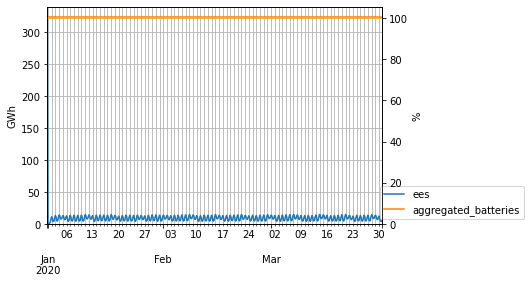

In [55]:
df = pd.concat([
    -ees_constraints_aggergated*10**-3, pd.Series(aggregated_max_battery*10**-3,level_index)
], axis = 1, keys = ["ees", "aggregated_batteries"]).resample("4h").mean()

ax = df.plot(ylabel="GWh", label = 'level_values')

ax.legend(bbox_to_anchor=(0.98,0.2))
ax2 = ax.twinx()
ax2.spines['right'].set_position(('axes',  1))
ax2 = pd.Series(100,df.index).plot(color="orange", ylabel="%")

ax.set_ylim(0), ax2.set_ylim(0)
ax.grid('on', which='minor' )
ax.grid('on', which='major' )

#plt.savefig(os.path.join(pics, 'ees_battery_comparison.png'), bbox_inches = "tight")

In [56]:
consumption_aggregated =  pd.concat([
    pd.Series(0, index=[index[0]-pd.Timedelta(pd.infer_freq(index))]), df_con.loc[level_index[1:]].sum(1)
              ], axis = 0)
consumption_aggregated.name = "consumption"

power_aggregated = pd.concat([
    pd.Series(0, index=[index[0]-pd.Timedelta(pd.infer_freq(index))]), df_pow.loc[level_index[1:]].sum(1)
              ], axis = 0)

neg_power_aggregated = pd.concat([
    pd.Series(0, index=[index[0]-pd.Timedelta(pd.infer_freq(index))]), df_neg_pow.loc[level_index[1:]].sum(1)
              ], axis = 0)

In [57]:
#aggregation
naive_constraints_aggergated = pd.Series(data=sum(
    df_pro.loc["battery_capacity"][ :profiles]), index=level_index) #all battery capicities

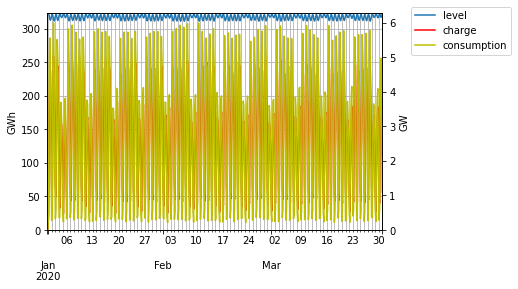

In [58]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax = (uncontrolled_level_accurate*10**-3).resample("4h").mean().plot(label = 'level', ylabel="GWh")

ax2 = ax.twinx()
ax2.spines['right'].set_position(('axes',  1))
ax2 = (uncontrolled_charge_accurate*10**-3).resample("4h").mean().plot(label = "charge", color="r", ylabel="GW")
ax2 = (consumption_aggregated*10**-3).resample("4h").mean().plot( label = "consumption", color="y")

##.loc[level_index.day == 3].

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2,  loc='best', bbox_to_anchor=(1.4, 1.05))


ax.set_ylim(0), ax2.set_ylim(0)
ax.grid('on', which='minor' )
ax.grid('on', which='major' )


#plt.savefig(os.path.join(pics, 'uncontrolled_level_1.png'), bbox_inches = "tight")

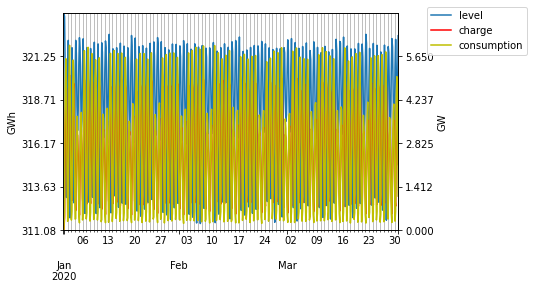

In [59]:
fig = plt.figure()
ax = fig.add_subplot(111)

ts = uncontrolled_level_accurate*10**-3
ax = (ts).resample("4h").mean().plot(label = 'level', ylabel="GWh")

ax2 = ax.twinx()
ax2.spines['right'].set_position(('axes',  1))
ts_2 = uncontrolled_charge_accurate*10**-3
ts_3 = consumption_aggregated*10**-3
ax2 = (ts_2).resample("4h").mean().plot(label = "charge", color="r", ylabel="GW")
ax2 = (ts_3).resample("4h").mean().plot( label = "consumption", color="y")

##.loc[level_index.day == 3].

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2,  loc='best', bbox_to_anchor=(1.4, 1.05))

ax.grid('on', which='minor', axis='x' )

for i, s in enumerate([ts, ts_3]):
    if i == 0: 
        ax.set_ylim(s.min(), s.max())
        step_size = (s.max() - s.min())/5
        ax.set_yticks(np.arange(s.min(), s.max(), step_size))
    else:
        ax2.set_ylim(s.min(), s.max())
        step_size = (s.max() - s.min())/5
        ax2.set_yticks(np.arange(s.min(), s.max(), step_size))
    



#plt.savefig(os.path.join(pics, 'uncontrolled_level.png'), bbox_inches = "tight")

In [60]:
uncontrolled_charge_accurate.max()*10**-3 #GW

5.430533523391784

## Aggregated Optimization

In [61]:
#!pip install pickle5
import pickle5 as pickle
with open("prices_2020", "rb") as fh:
    data = pickle.load(fh)

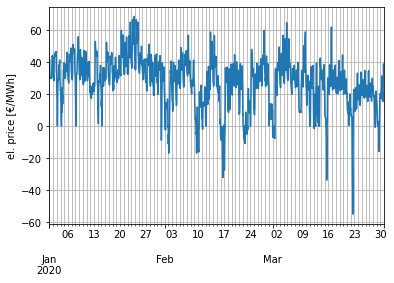

In [62]:
price_mode = "real_price"
prices = data
 
prices.index =  prices.index.map(
    lambda x: pd.to_datetime(x.replace(tzinfo=None))
)
prices = prices[prices.index.drop_duplicates(keep=False)]
prices = prices.reindex(consumption_aggregated.index, method = "ffill") 
prices = prices / (10**3) # €/MWh --> €/kWh

ax = (prices*1000).plot(ylabel="el. price [€/MWh]")

ax.grid('on', which='minor', axis='x' )
ax.grid('on', which='major')

#plt.savefig(os.path.join(pics, 'prices.png'), bbox_inches = "tight")

In [63]:
#prices = pd.Series(0, prices.index)
#prices[df_con.sum(1).nlargest(1).index] = 1
#price_mode = "artificial_price"

((0.0, 0.06784799999999999), (0.0, 6298.050126781802))

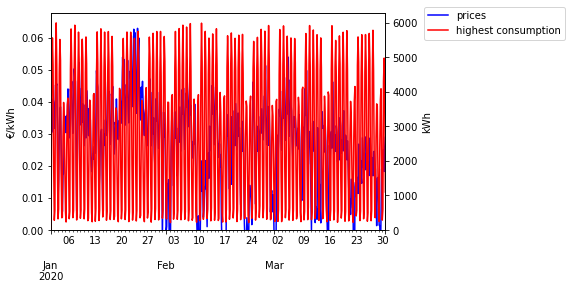

In [64]:
ax = fig.add_subplot(111)

ax = prices.resample("4h").mean().plot(ylabel="€/kWh", color="b", ylim=(0), label="prices")

ax2 = ax.twinx()
ax2.spines['right'].set_position(('axes',  1))

ax2= df_con.sum(1).resample("4h").mean().plot(label = "highest consumption",  ylim=(0), color="r", ylabel="kWh")

##.loc[level_index.day == 3].

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2,  loc='best', bbox_to_anchor=(1.55, 1.05))

ax.set_ylim(0), ax2.set_ylim(0)


Assumptions: 

- same price for (DIS)CHARGE
- 𝑓𝑙𝑒𝑥𝑖𝑏𝑖𝑙𝑖𝑡𝑦 𝑟𝑒𝑣𝑒𝑛𝑢𝑒𝑠 = sum(ees_charging_costs)
- controlled costs = uncontrolled_costs - 𝑙𝑒𝑥𝑖𝑏𝑖𝑙𝑖𝑡𝑦 𝑟𝑒𝑣𝑒𝑛𝑢𝑒𝑠 

In [68]:
agg_solutions = {}

for model_type in ["naive", "ees"]: 

    #Initialize model
    m_agg = pyo.ConcreteModel()

    #initialize sets
    m_agg.t = pyo.Set(initialize = ees_constraints_aggergated.index, ordered = True)

    m_agg.consumption_aggregated = pyo.Param(m_agg.t, initialize=consumption_aggregated.to_dict())
    m_agg.power = pyo.Param(m_agg.t, initialize=power_aggregated.to_dict()) 
    m_agg.neg_power = pyo.Param(m_agg.t, initialize=neg_power_aggregated.to_dict()) 

    m_agg.LEVEL = pyo.Var(m_agg.t, within = pyo.Reals)
    m_agg.CHARGE = pyo.Var(m_agg.t, within = pyo.NonNegativeReals)
    m_agg.DISCHARGE_PHYS = pyo.Var(m_agg.t, within = pyo.NonNegativeReals)
    m_agg.DISCHARGE_WAIT = pyo.Var(m_agg.t, within = pyo.NonNegativeReals)

    if model_type == "ees":
        m_agg.ees_min = pyo.Param(m_agg.t, initialize=ees_constraints_aggergated.to_dict()) 
        m_agg.uncontrolled_charge = pyo.Param(m_agg.t, initialize=uncontrolled_charge_accurate.to_dict()) 
        
        #recursive level
        def recursive_level(m_agg, t):
            if t == level_index[0]:
                return m_agg.LEVEL[t] == (m_agg.CHARGE[t] - m_agg.DISCHARGE_WAIT[t] - m_agg.DISCHARGE_PHYS[t])*step_duration   
            else:
                return m_agg.LEVEL[t] == m_agg.LEVEL[pd.Timestamp(t) - 
                                                 pd.Timedelta(pd.infer_freq(index))] + (
                    m_agg.CHARGE[t] - m_agg.DISCHARGE_WAIT[t] - m_agg.DISCHARGE_PHYS[t]) * step_duration   
            
    else:
        def final_level(m_agg, t):
            if t == index[-1]:
                return m_agg.LEVEL[t] == level_T_agg
            else: 
                return pyo.Constraint.Skip
        m_agg.Final_level = pyo.Constraint(m_agg.t, rule=final_level)
        
        def recursive_level(m_agg, t):
            if t == level_index[0]: 
                return m_agg.LEVEL[t] == level_0_agg + (m_agg.CHARGE[t]- m_agg.consumption_aggregated[t] - m_agg.DISCHARGE_PHYS[t] )*step_duration   
            else:
                return m_agg.LEVEL[t] == m_agg.LEVEL[pd.Timestamp(t) - 
                                                 pd.Timedelta(pd.infer_freq(index))] + (
                    m_agg.CHARGE[t] - m_agg.consumption_aggregated[t] - m_agg.DISCHARGE_PHYS[t]) * step_duration 
            
       
    m_agg.Recursive_level = pyo.Constraint(m_agg.t, rule = recursive_level)
    
    def level_constraint(m_agg, t):
        if model_type=="ees":
            return m_agg.LEVEL[t] >= m_agg.ees_min[t] 
        else:
            return m_agg.LEVEL[t] <= aggregated_max_battery
    m_agg.Level_constraint = pyo.Constraint(m_agg.t, rule=level_constraint)
    
    def level_constraint_2(m_agg, t):
        if model_type=="ees":
            return m_agg.LEVEL[t] <= 0
        else:
            return m_agg.LEVEL[t] >= 0
    m_agg.Level_constraint_2 = pyo.Constraint(m_agg.t, rule=level_constraint_2)
    
    #if (model_type == "naive")  & (flex=="constrained"): ####
     #   dep_index = consumption_aggregated[(consumption_aggregated==0) & (consumption_aggregated.shift(-1) > 0) == True].index
      #  m_agg.t_dep = pyo.Set(initialize = dep_index, ordered = True)

      #  def full_before_next_trip(m_agg, t_dep):
       #     return m_agg.LEVEL[t_dep] >= uncontrolled_level_accurate[dep_index].loc[t_dep]
        #m_agg.Full_before_next_trip = pyo.Constraint(m_agg.t_dep, rule=full_before_next_trip)
                    
    def power_discharge_phys_max(m_agg, t):
        if V2G == True:
            return m_agg.DISCHARGE_PHYS[t] <= m_agg.neg_power[t] 
        else: 
            return m_agg.DISCHARGE_PHYS[t] == 0
    m_agg.Power_discharge_phys_max = pyo.Constraint(m_agg.t, rule=power_discharge_phys_max)

    if model_type == "ees":
        def power_charge_max(m_agg, t):
            return m_agg.CHARGE[t] <= m_agg.power[t] - m_agg.uncontrolled_charge[t] 
        
        def power_discharge_consumption_max(m_agg, t):
                return m_agg.DISCHARGE_WAIT[t] <=  m_agg.uncontrolled_charge[t] 
        m_agg.Power_discharge_consumption_max = pyo.Constraint(m_agg.t, rule=power_discharge_consumption_max)
    else:
        def power_charge_max(m_agg, t):
            return m_agg.CHARGE[t] <= m_agg.power[t]   
    m_agg.Power_charge_max = pyo.Constraint(m_agg.t, rule=power_charge_max)
    
    # objective function
    if model_type == "ees":
        def min_ees_costs(m_agg): 
            return sum(
                (m_agg.CHARGE[t]-m_agg.DISCHARGE_WAIT[t]-m_agg.DISCHARGE_PHYS[t]
                ) * prices[t] *step_duration 
                for t in m_agg.t
            ) 
        m_agg.Obj_min_ees_costs = pyo.Objective(rule=min_ees_costs, sense=pyo.minimize)
    else:
        def min_naive_costs(m_agg): 
            return sum(
                (m_agg.CHARGE[t] - m_agg.DISCHARGE_PHYS[t]) * prices[t] *step_duration 
                for t in m_agg.t
            ) 
        m_agg.Obj_min_naive_costs = pyo.Objective(rule=min_naive_costs, sense=pyo.minimize)
        
    #find solver
    solvername='glpk'

    #prepare solver
    optimizer = opt.SolverFactory(solvername) 
    solved_model = optimizer.solve(m_agg, tee=True)        
    
    agg_solutions[model_type] = {}
    agg_solutions[model_type]["costs"] = solved_model['Problem']()['Lower bound']
    agg_solutions[model_type]["CHARGE"] = pd.DataFrame.from_dict(m_agg.CHARGE.extract_values(), orient='index', columns = [model_type])
    if model_type == "ees":
        agg_solutions[model_type]["DISCHARGE"] = pd.DataFrame.from_dict(m_agg.DISCHARGE_WAIT.extract_values(), orient='index', columns = [model_type]) + pd.DataFrame.from_dict(m_agg.DISCHARGE_PHYS.extract_values(), orient='index', columns = [model_type])
    else:
        agg_solutions[model_type]["DISCHARGE"] = pd.DataFrame.from_dict(m_agg.DISCHARGE_PHYS.extract_values(), orient='index', columns = [model_type])
    agg_solutions[model_type]["LEVEL"] = pd.DataFrame.from_dict(m_agg.LEVEL.extract_values(), orient='index', columns = [model_type])

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write /var/folders/xb/lfd6_z7178g_6zv_ygw5vd4m0000gp/T/tmpza97uxfb.glpk.raw
 --wglp /var/folders/xb/lfd6_z7178g_6zv_ygw5vd4m0000gp/T/tmp8oiiyhhc.glpk.glp
 --cpxlp /var/folders/xb/lfd6_z7178g_6zv_ygw5vd4m0000gp/T/tmp6x6hydvj.pyomo.lp
Reading problem data from '/var/folders/xb/lfd6_z7178g_6zv_ygw5vd4m0000gp/T/tmp6x6hydvj.pyomo.lp'...
21608 rows, 12964 columns, 34570 non-zeros
120995 lines were read
Writing problem data to '/var/folders/xb/lfd6_z7178g_6zv_ygw5vd4m0000gp/T/tmp8oiiyhhc.glpk.glp'...
99376 lines were written
GLPK Simplex Optimizer 5.0
21608 rows, 12964 columns, 34570 non-zeros
Preprocessing...
4312 rows, 4313 columns, 8624 non-zeros
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 4312
      0: obj =   1.763581636e+05 inf =   6.016e+05 (2)
    267: obj =   1.764026734e+05 inf =

def plot_aggregated_results(model_type):
    obversvations = 100#len(ees_constraints_aggergated)
    x = level_index[10:obversvations]
    fig, ax = plt.subplots(3)
    ax[0].step(x, 
               pyo.value(agg_solutions[model_type]["CHARGE"].values[10:obversvations]), where="pre")
    ax[0].set_title("{}_charging".format(model_type))
    
    
    ax[1].step(x, 
               pyo.value(agg_solutions[model_type]["DISCHARGE"].values[10:obversvations]), where="pre")
    ax[1].set_title("{}_discharging".format(model_type))
    
    
    ax[2].plot(x, 
               pyo.value(agg_solutions[model_type]["LEVEL"].values[10:obversvations]))
    ax[2].set_title("{}_level".format(model_type))
    ax[2].set_ylabel("kWh")
    
    
    for i in range(0,2):
        ax[i].set_ylabel("kWh/15min")
        ax[i].set_xticks(pd.date_range(x[0], x[-1], freq="D"))
        #plt.set_xticklabels(rotation= 45)
        plt.xticks(rotation= 45)
    fig.autofmt_xdate(rotation=45)


    plt.tight_layout()
    plt.show()
    
plot_aggregated_results("ees")
plot_aggregated_results("naive")

# Analysis

In [69]:
agg_overest_solutions = {}

for model_type in ["m_early_agg", "m_late_agg"]:
    #Initialize model
    m_agg = pyo.ConcreteModel()

    #initialize sets
    m_agg.t = pyo.Set(initialize = ees_constraints_aggergated.index, ordered = True)

    m_agg.consumption_aggregated = pyo.Param(m_agg.t, initialize=consumption_aggregated.to_dict())
    m_agg.power = pyo.Param(m_agg.t, initialize=power_aggregated.to_dict()) 
    m_agg.neg_power = pyo.Param(m_agg.t, initialize=neg_power_aggregated.to_dict()) 

    m_agg.LEVEL = pyo.Var(m_agg.t, within = pyo.NonNegativeReals, bounds=(
        0, aggregated_max_battery))
    m_agg.CHARGE = pyo.Var(m_agg.t, within = pyo.NonNegativeReals)
    m_agg.DISCHARGE = pyo.Var(m_agg.t, within = pyo.NonNegativeReals)
    
    if (model_type == "m_late_agg")  & (flex=="constrained"): ###
        dep_index = consumption_aggregated[(consumption_aggregated==0) & (consumption_aggregated.shift(-1) > 0) == True].index
        m_agg.t_dep = pyo.Set(initialize = dep_index, ordered = True)
        def full_before_next_trip(m_agg, t_dep):
            return m_agg.LEVEL[t_dep] >= uncontrolled_level_accurate[dep_index].loc[t_dep]
        ###m_agg.Full_before_next_trip = pyo.Constraint(m_agg.t_dep, rule=full_before_next_trip)
        
        
    #level constraints
    def recursive_level(m_agg, t):
        if t == level_index[0]:
            return m_agg.LEVEL[t] == level_0_agg + m_agg.CHARGE[t] - m_agg.consumption_aggregated[t]
        else:    
            return m_agg.LEVEL[t] == m_agg.LEVEL[pd.Timestamp(t) - 
                                             pd.Timedelta(pd.infer_freq(level_index))] + (
                m_agg.CHARGE[t] - m_agg.consumption_aggregated[t] - m_agg.DISCHARGE[t] )
    m_agg.Recursive_level = pyo.Constraint(m_agg.t, rule = recursive_level)
    
    def final_level(m_agg, t):
        if t == index[-1]:
            return m_agg.LEVEL[t] == level_T_agg
        else: 
            return pyo.Constraint.Skip
    m_agg.Final_level = pyo.Constraint(m_agg.t, rule=final_level)
    
    #bidirectional charging 
    def neg_power_min(m_agg, t):
        if V2G == True:
            return m_agg.DISCHARGE[t] <= m_agg.neg_power[t]
        else: 
            return m_agg.DISCHARGE[t] == 0
    m_agg.Neg_power_min_restriction = pyo.Constraint(m_agg.t, rule=neg_power_min)

    def power_max(m_agg, t):
        return m_agg.CHARGE[t] <= m_agg.power[t]   
    m_agg.Power_max_restriction = pyo.Constraint(m_agg.t, rule=power_max)
    
    def final_level(m_agg, t):
        if t == index[-1]:
            return m_agg.LEVEL[t] == level_T_agg
        else: 
            return pyo.Constraint.Skip
    m_agg.Final_level = pyo.Constraint(m_agg.t, rule=final_level)

    # objective function late
    def battery_level_sum(m_agg, t): 
        return sum(m_agg.LEVEL[t] for t in m_agg.t) 
    if model_type == "m_late_agg":
        sense = pyo.minimize
    elif model_type == "m_early_agg":
        sense = pyo.maximize     
    m_agg.Obj = pyo.Objective(rule=battery_level_sum, sense=sense)

    #find solver
    solvername='glpk'

    #prepare solver
    optimizer = opt.SolverFactory(solvername) 
    solved_model = optimizer.solve(m_agg, tee=True)        

    #store data in dictionary
    agg_overest_solutions[model_type] = pd.DataFrame.from_dict(
        m_agg.LEVEL.extract_values(), orient='index')[0]

    'pyomo.core.base.constraint.IndexedConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.IndexedConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write /var/folders/xb/lfd6_z7178g_6zv_ygw5vd4m0000gp/T/tmp5fdqc018.glpk.raw
 --wglp /var/folders/xb/lfd6_z7178g_6zv_ygw5vd4m0000gp/T/tmpixu__c2n.glpk.glp
 --cpxlp /var/folders/xb/lfd6_z7178g_6zv_ygw5vd4m0000gp/T/tmpu_8h5qoo.pyomo.lp
Reading problem data from '/var/folders/xb/lfd6_z7178g_6zv_ygw5vd4m0000gp/T/tmpu_8h5qoo.pyomo.lp'...
12965 rows, 12964 columns, 25926 non-zeros
82113 lines were read
Writing problem data to '/var/folders/xb/lfd6_z7178g_6zv_ygw5vd4m0000gp/T/tmpixu__c2n.glpk.glp'...
69137 lines were written
GLPK Simplex Optimizer 5.0
12965 rows, 12964 columns, 25926 non-zeros
Preprocessing...
4312 rows, 4313 c

In [ ]:
#power
#naive
neg_power_aggregated.mean()
power_aggregated.mean()

#EES
(neg_power_aggregated+uncontrolled_charge_accurate).mean()
(power_aggregated-uncontrolled_charge_accurate).mean()

In [70]:
#overestimation in kWh how much could be shifted from uncontrolled charging?
overestimation_dict = {}

overestimation = 1 + (
    (agg_overest_solutions["m_late_agg"] - agg_overest_solutions["m_early_agg"]).sum()
    - ees_constraints_aggergated.sum()
) / ees_constraints_aggergated.sum()

print(
    "potential overestimation factor: " + str(
        overestimation) + " : " + str((
    (agg_overest_solutions["m_late_agg"] - agg_overest_solutions["m_early_agg"]).sum()
    - ees_constraints_aggergated.sum()
) / ees_constraints_aggergated.sum()*100) + " %"
)
                                                  
overestimation_dict[f'profiles: {profiles}, steps: {time_steps}'] =  overestimation 

potential overestimation factor: 34.88542860294825 : 3388.542860294825 %


#df = pd.DataFrame().from_dict(overestimation_dict, orient="index")
df_profiles = df.iloc[:7]
df_profiles.index = [int(
    i.split(":")[1].split(",")[0]
)
 for i in df_profiles.index]

df_profiles.to_pickle("profiles_overestimation")
df_profiles.plot()
plt.legend(["time_steps: 673"])

df_time_steps = df.iloc[7:]
df_time_steps.index = [int(
    i.split(",")[1].split(":")[1]
)
 for i in df_time_steps.index]

df_time_steps.to_pickle("time_step_overestimation")
df_time_steps.plot()
plt.legend(["profiles: 3311"])

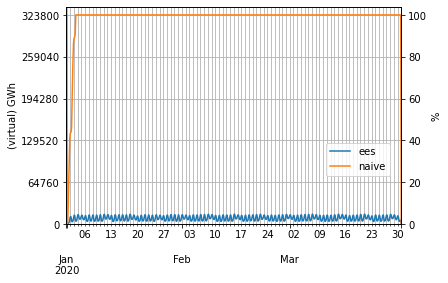

In [134]:
overestimated = (agg_overest_solutions["m_early_agg"] - agg_overest_solutions["m_late_agg"])

ts = pd.concat([
    -ees_constraints_aggergated ,overestimated
], axis = 1, keys = ["ees", "naive"])

ax = ts.plot(ylabel="(virtual) GWh")

ax.legend(bbox_to_anchor=(0.98,0.2))

ax2 = ax.twinx()
ax2.spines['right'].set_position(('axes',  1))

ts_2 = pd.Series(100,level_index)
ax2 = ts_2.plot(alpha=0, ylabel="%")

ax.set_ylim(0), ax2.set_ylim(0)


ax.grid('on', which='minor', axis='x' )
ax.grid('on', which='major' )

max_val = 10 - int(overestimated.max()) % 10 + int(overestimated.max())

for i, s in enumerate([ts, ts_2]):
    if i == 0: 
        step_size = (max_val)/5 
        ax.set_ylim(0, max_val+step_size/5)
        ax.set_yticks(np.arange(0,max_val+1, step_size))
    else:
        step_size = 100/5
        ax2.set_ylim(0, 100 +step_size/5)
        ax2.set_yticks(np.arange(0,101, step_size))

#plt.savefig(os.path.join(pics, 'level_comparison_size_ts.png'), bbox_inches = "tight")

In [145]:
(ts.apply(lambda r: (r["naive"]-r["ees"])/r["naive"], axis=1)*100).describe()

/Users/Jarusch/opt/anaconda3/envs/emobpyenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in double_scalars
  """Entry point for launching an IPython kernel.
/Users/Jarusch/opt/anaconda3/envs/emobpyenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """Entry point for launching an IPython kernel.


count    4314.000000
mean            -inf
std              NaN
min             -inf
25%        96.111984
50%        97.239861
75%        98.202458
max        98.807240
dtype: float64

In [72]:
ees_constraints_aggergated.sum()*10**-6



-39.500560744651736

Text(0, 0.5, '%')

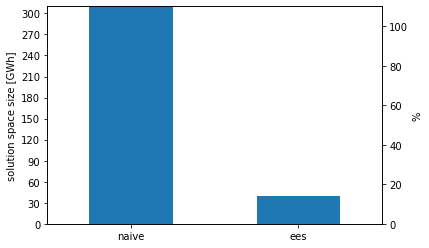

In [73]:
ts = pd.DataFrame([
    (agg_overest_solutions["m_early_agg"] - agg_overest_solutions["m_late_agg"]).sum()*10**-6,
    -ees_constraints_aggergated.sum()*10**-6
], ["naive", "ees"])

ax = ts.plot.bar(rot=0, legend=False )


ax.set_ylabel("solution space size [GWh]")

ax2 = ax.twinx()

ax2.spines['right'].set_position(('axes',  1))




ax.set_ylim(0 ,310)
step_size = (300)/10
ax.set_yticks(np.arange(0, 310, step_size))
 
ax2.set_ylim(0, 110)
step_size = 100/5
ax2.set_yticks(np.arange(0,110, step_size))
ax2.set_ylabel("%")


#plt.savefig(os.path.join(pics,'level_comparison_size_bar.png'), bbox_inches = "tight")


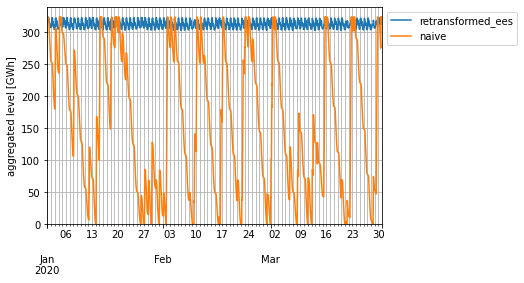

In [74]:
#controlled charging (physical) = uncontrolled charging - ees_dis + ee_scharging
#fig, ax = plt.subplots()

retransformed_ees_level = pd.concat([
    uncontrolled_level_accurate, agg_solutions["ees"]["LEVEL"]
], axis=1).sum(1)
retransformed_ees_level.name = "retransformed_ees"

ax = (pd.concat([
    retransformed_ees_level, agg_solutions["naive"]["LEVEL"]
], axis=1)*10**-3).plot(ylabel="aggregated level [GWh]", ylim=0)

#.loc[level_index.day <= 7]
ax.grid('on', which='minor', axis='x' )
ax.grid('on', which='major' )

plt.legend(bbox_to_anchor=(1.0, 1.0))


#fig.tight_layout()
#plt.savefig(os.path.join(pics, price_mode,'opt_level_comparison_long.png'), bbox_inches = "tight")#week

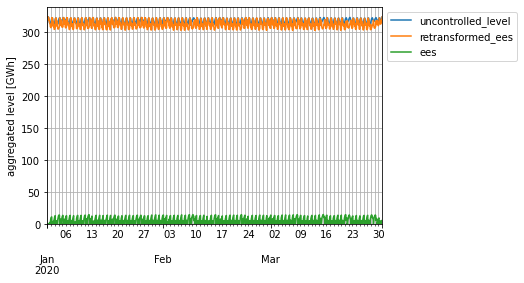

In [75]:
ax = (pd.concat([
    uncontrolled_level_accurate, retransformed_ees_level, -agg_solutions["ees"]["LEVEL"]
], axis=1)*10**-3).plot(ylabel="aggregated level [GWh]", ylim=0)

ax.grid('on', which='minor', axis='x' )

ax.grid('on', which='major' )

plt.legend(bbox_to_anchor=(1.0, 1.0))

#plt.savefig(os.path.join(pics, price_mode,'shifted_energy.png'), bbox_inches = "tight") #long, week, day_3

In [76]:
-agg_solutions["ees"]["LEVEL"].sum()*10**-6

ees    22.752774
dtype: float64

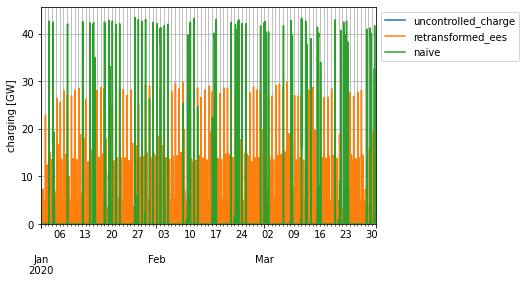

In [78]:
#controlled charging (physical) = uncontrolled charging - ees_dis + ee_scharging

retransformed_ees_charge = pd.concat([
    uncontrolled_charge_accurate.loc[level_index[1:]], agg_solutions["ees"]["CHARGE"], - agg_solutions["ees"]["DISCHARGE"]
], axis=1).sum(1)

charge_list = [agg_solutions["naive"]["CHARGE"]]
if V2G==True: charge_list.append(- agg_solutions["naive"]["DISCHARGE"])
naive_dis_charge = pd.concat(charge_list, axis=1).sum(1)

retransformed_ees_charge.name, naive_dis_charge.name = "retransformed_ees", "naive"

df_list = [uncontrolled_charge_accurate, retransformed_ees_charge, naive_dis_charge]
df_list = [df*10**-3 for df in df_list]
ax = pd.concat(df_list, axis=1).plot(ylabel="charging [GW]", ylim=(0))
ax.grid('on', which='minor', axis='x' )
ax.grid('on', which='major' )
#.loc[level_index.day <= 7]
plt.legend(bbox_to_anchor=(1.0, 1.0))

#plt.savefig(os.path.join(pics, price_mode,'all_charging.png'), bbox_inches = "tight") #long, week, day_3

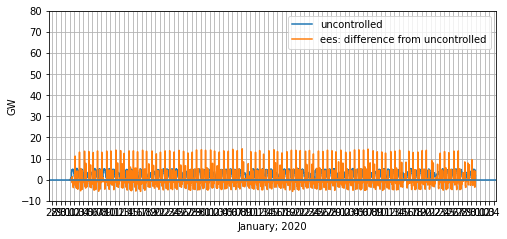

In [79]:
    fig, ax = plt.subplots(figsize=(8, 3.5))

ts =  (pd.concat([
    uncontrolled_charge_accurate, agg_solutions["ees"]["CHARGE"]-agg_solutions["ees"]["DISCHARGE"]
], axis=1)*10**-3).resample("h").mean()


ax.step(ts.index, ts, where="post")
ax.set_ylabel("GW")
ax.set_xlabel("January; 2020")
ax.set_ylim(-10,80)
plt.axhline(y=0)
ax.xaxis.set_major_locator(mdates.DayLocator(interval = 1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d'))

ax.legend(["uncontrolled", "ees: difference from uncontrolled"], bbox_to_anchor=(1.0, 1.0))

plt.grid()

#plt.savefig(os.path.join(pics, 'shifted_charge.png'), bbox_inches = "tight")

In [80]:
#plausibility: charging the same in all strategies? 
pd.concat([
    uncontrolled_charge_accurate, retransformed_ees_charge, naive_dis_charge.iloc[1:]
], axis=1).sum(0)

uncontrolled_charge    1.177310e+07
retransformed_ees      1.177310e+07
naive                  1.177310e+07
dtype: float64

In [81]:
pd.concat([retransformed_ees_level, agg_solutions["naive"]["LEVEL"]], axis=1).iloc[-1]

retransformed_ees    323796.28
naive                323796.28
Name: 2020-03-30 23:30:00, dtype: float64

## Cost

In [82]:
uncontrolled_costs = sum([
    uncontrolled_charge_accurate[i] * prices[i] for i in index
])
controlled_costs_ees = sum([
    retransformed_ees_charge[i] * prices[i] for i in index
])
controlled_costs_naive = sum([
    naive_dis_charge[i] * prices[i] for i in index
])

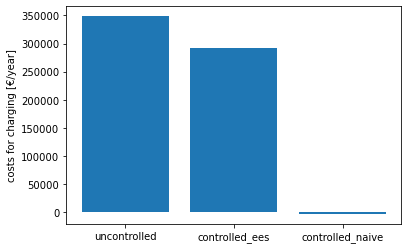

In [84]:
#costs
fig, ax = plt.subplots()

plt.bar(x = ["uncontrolled", "controlled_ees", "controlled_naive"],  height=[
    uncontrolled_costs, controlled_costs_ees, controlled_costs_naive
])
plt.ylabel("costs for charging [€/year]")
plt.show()

fig.tight_layout()
#plt.savefig(os.path.join(pics, price_mode,'costs.pdf'),  bbox_inches = "tight") 

Text(0, 0.5, 'cost benefit: ees/naive [-]')

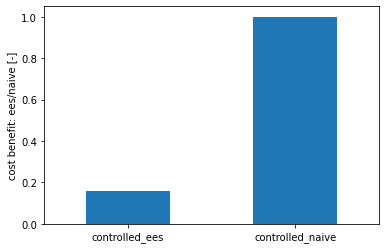

In [86]:

ax = pd.DataFrame([
    (controlled_costs_ees-uncontrolled_costs)/(controlled_costs_naive-uncontrolled_costs), 1
], ["controlled_ees", "controlled_naive"]).plot.bar(rot=0, legend=False )


ax.set_ylabel("cost benefit: ees/naive [-]")


#plt.savefig(os.path.join(pics, price_mode,'costs_percent.png'), bbox_inches = "tight") 

## Scaling

In [87]:
fleeet_size = 10**6 

In [88]:
costs = pd.DataFrame()
solution_space = pd.DataFrame()
solution_space['ees_0'] = -ees_constraints_aggergated*10**-3

solution_space_bar = pd.DataFrame()
costs = pd.DataFrame([
    controlled_costs_ees
], ["0"])

soc_min_list =  [ "0.1", "0.2", "0.3"]

for s in soc_min_list:#"0",
    raw = pd.read_pickle(f"solution_spaces_ts_{s}").rename(columns= {"ees":f"ees_{s}"})
    solution_space = pd.concat([solution_space, raw[f"ees_{s}"]], axis = 1)
    ts = pd.read_pickle(f"costs_{s}").rename(columns= {0:f"{s}"}).iloc[0]
    costs= pd.concat([costs, ts], axis = 0)
    
solution_space['naive'] = raw ["naive"]
solution_space_bar = solution_space.sum(0) 


soc_min_list.insert(0,"0")


FileNotFoundError: [Errno 2] No such file or directory: 'solution_spaces_ts_0.1'

In [ ]:
costs.loc["naive"] = controlled_costs_naive

In [ ]:
ax = (costs/1000).plot.bar(rot=0, legend=False)
ax.set_ylabel("costs for charging [1,000€/year]")


ax2.set_ylim(0,100)


plt.savefig(os.path.join(pics, 'costs_soc_min.png'), bbox_inches = "tight") 

In [ ]:
ts = solution_space

ax = ts.plot(ylabel="(virtual) GWh")
ax.legend(bbox_to_anchor=(1.1,1))


ax2 = ax.twinx()
ax2.spines['right'].set_position(('axes',  1))

ts_2 = pd.Series(100,level_index)
ax2 = ts_2.plot(alpha=0, ylabel="%")


ax.set_ylim(0), ax2.set_ylim(0)


ax.grid('on', which='minor', axis='x' )
ax.grid('on', which='major' )

for i, s in enumerate([ts, ts_2]):
    if i == 0: 
        ax.set_ylim(0, 550)
        step_size = (500)/5
        ax.set_yticks(np.arange(0, 550, step_size))
    else:
        ax2.set_ylim(0, 110)
        step_size = 100/5
        ax2.set_yticks(np.arange(0,110, step_size))


plt.savefig(os.path.join(pics, 'level_comparison_soc_min_ts.png'))

In [ ]:

ts = solution_space_bar*10**-3

ax = ts.plot.bar(rot=0, legend=False )


ax.set_ylabel("solution space size [GWh]")

ax2 = ax.twinx()

ax2.spines['right'].set_position(('axes',  1))

ax.set_ylim(0 , 330)
step_size = (300)/5
ax.set_yticks(np.arange(0,330, step_size))
 
ax2.set_ylim(0, 110)
step_size = 100/5
ax2.set_yticks(np.arange(0,110, step_size))
ax2.set_ylabel("%")


ax.grid('on', which='minor', axis='x' )

plt.savefig(os.path.join(pics,'level_comparison_size_bar.png'), bbox_inches = "tight")


In [ ]:
overestimation_factors = pd.Series( [1.7689430340159902, 1.8651748933840055, 1.9937007078507452, 2.1678926919803545],  solution_space_bar[:-1].index
                                )

overestimation_factors.plot.bar(rot=0)

plt.savefig(os.path.join(pics,'level_comparison_size_bar.png'), bbox_inches = "tight")
